In [628]:
"""
=======================================
Custom hillshading in a 3D surface plot
=======================================

Demonstrates using custom hillshading in a 3D surface plot.
"""
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

In [629]:
import pandas as pd

In [630]:
import seaborn as sns
%matplotlib inline

In [631]:
sns.set_theme(style='ticks')

# Load and format data
filename = cbook.get_sample_data('jacksboro_fault_dem.npz', asfileobj=False)
with np.load(filename) as dem:
    z = dem['elevation']
    nrows, ncols = z.shape
    x = np.linspace(dem['xmin'], dem['xmax'], ncols)
    y = np.linspace(dem['ymin'], dem['ymax'], nrows)
    X, Y = np.meshgrid(x, y)

region = np.s_[10:60, 0:50]
raw_x, raw_y, raw_z = X[region], Y[region], z[region]

In [632]:
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def compute_euclidean_distance(i,j,start_point):
    """
    compute distance for meshgrid coordinates
    """
    
    X_coord = raw_x[i,j]
    Y_coord = raw_y[i,j]
    
    dist = (X_coord - start_point[0])**2 + (Y_coord - start_point[1])**2
    return np.sqrt(dist)

def pad_with_head_tail(df, col, pad_to):
    """
    pad the array to desired length, inserting with closest values
    Args:
        df: dataframe that stored the array
        col: which columns will be used
        pad_to: the length
    Return:
        the padded array 
    """
    col_index = {'x':0,'z':2}[col]
    Array = df[col].values
    
    diff = pad_to -  df.shape[0]
    
    if diff == 0:
        
        # needs no padding
        return Array
    else:
        # the closet values are head and tail
        head = np.full(diff//2 ,Array[0].item()) 
        tail = np.full(diff//2 ,Array[-1].item())

        return np.concatenate([head, Array, tail],axis=0)
        

    
def fetch_corcords_in_circle(library_size, start_point, raw_x=raw_x, raw_y=raw_y, raw_z=raw_z):
    """
    library_size : the radius of the circle
    start_point : the center of the circle
    raw_x, raw_y, raw_z: the global landscape
    
    Return:
        [X|Y|Z]_incircle_coords : 3 arrays of the dots that are in the circle
    """

    in_circle = []
    z_in = []
    
    # iterate each dot, and compute the distance to the center of the circle
    for i in range(raw_x.shape[0]):
        for j in range(raw_y.shape[0]):
            dist = compute_euclidean_distance(i,j,start_point)

            if dist <= library_size:
                in_circle.append([raw_x[i,j],raw_y[i,j]])
                z_in.append(raw_z[i,j])
    
    # in fact, the coordinates of dots that are in the circle is all here in the df
    in_circle1_df = pd.DataFrame(in_circle,columns=['x','y'])
    in_circle1_df['z'] = z_in

    longest_n = in_circle1_df.x.nunique()

    X_incircle_coords = []
    Y_incircle_coords = []
    Z_incircle_coords = []

    
    # convert the dots in the df into meshgrish coords so that we can plot the surface
    #  1         111
    # 123   ->   123
    #  4         444
    # some array are shorter, we pad them into the same length
    for i in range(longest_n):
        
        # in the y direction
        # move a step of y
        y0=in_circle1_df.y.unique()[i]
        dy = in_circle1_df.query("`y` == @y0") # a small step of y : delta y

        Y_incircle_coords.append(np.full(longest_n, y0))

        # the margin : the length of X is short than X in the center
        X_incircle_coords.append(pad_with_head_tail(dy, 'x', longest_n))
        Z_incircle_coords.append(pad_with_head_tail(dy, 'z', longest_n))    


    X_incircle_coords = np.stack(X_incircle_coords)
    Y_incircle_coords = np.stack(Y_incircle_coords)
    Z_incircle_coords = np.stack(Z_incircle_coords)

    return X_incircle_coords, Y_incircle_coords, Z_incircle_coords 

## multiple libraries

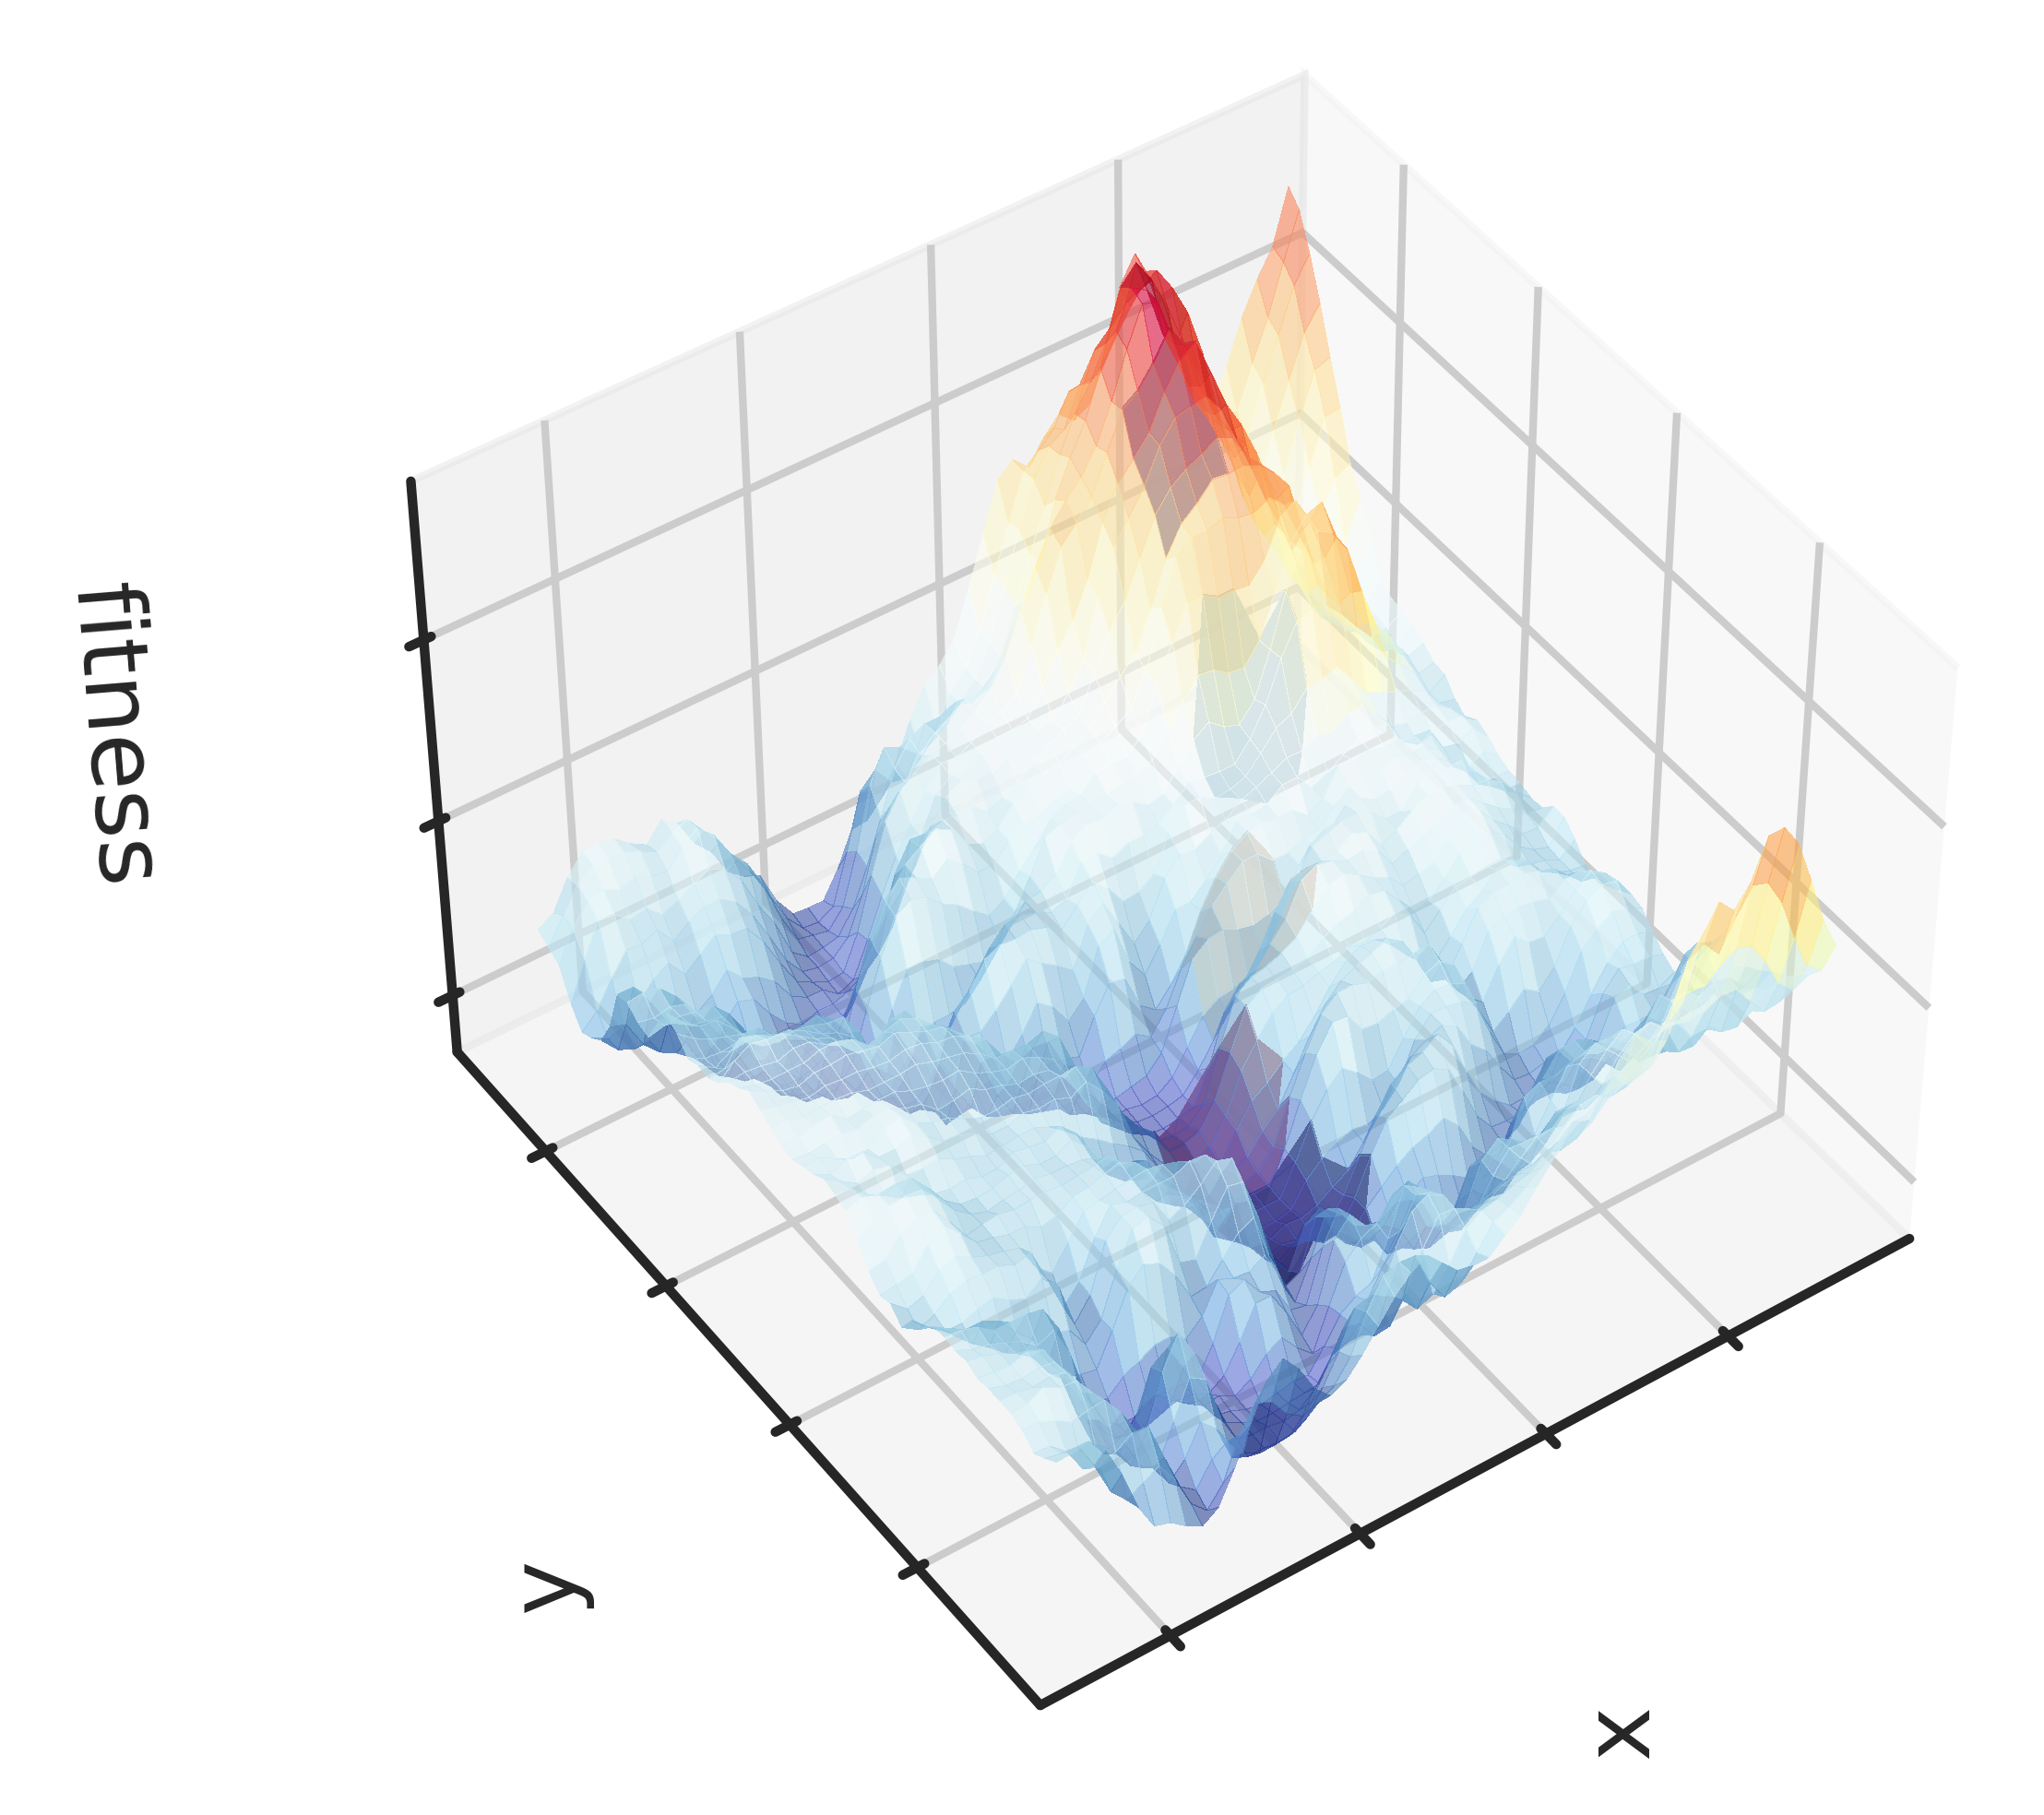

In [862]:
# Set up plot
fig, ax = plt.subplots(dpi=600,subplot_kw=dict(projection='3d'))



# ====================== global landscpe ===========================

ls = LightSource(-125, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(raw_z, cmap=cm.RdYlBu_r, vert_exag=0.1, blend_mode='soft')

# surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=False)

surf = ax.plot_surface(raw_x, raw_y, raw_z, linewidth=0, facecolors=rgb, alpha=0.6,
                       rcount=100, ccount=100 , # maximal number of dots in the surface
                       antialiased=False, shade=False)

# ax.scatter(raw_x[21,15], raw_y[21,15],raw_z[21,15],s=10,color='black' )

ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_zticklabels('')

ax.set_xlabel('x',rotation=90)

ax.set_ylabel('y',rotation=90)

ax.set_zlabel('fitness',rotation=90)



# ======================= stepwise searching ====================== 

# 5 libraries
library_size = 0.004
starts_x = [35,28,22,15,8] 
starts_y = [25,25,31,36,36]
           

for step in range(5):
    
    # center of the circle
    left = starts_x[step]
    right = starts_y[step]
    start_point=[raw_x[left,right],raw_y[left,right]]
    library_size -= 0.0003
    
    color = cm.twilight_shifted_r((step)/5)
    
    # coord
    X_incircle_coords, Y_incircle_coords, Z_incircle_coords = fetch_corcords_in_circle(library_size, start_point)
    
    ax.plot_surface(X_incircle_coords, Y_incircle_coords, Z_incircle_coords+1, alpha=0.9,
                       linewidth=0,  antialiased=False, shade=False, color=color);


# for step in range(4):
    
#     left = starts_x[step]
#     right = starts_y[step]
#     start_point=[raw_x[left,right],raw_y[left,right],raw_z[left,right]]
    
#     left = starts_x[step+1]
#     right = starts_y[step+1]
#     end_point=[raw_x[left,right],raw_y[left,right],raw_z[left,right]]
    
#     xs,ys,zs=list(zip(start_point,end_point))
#     arw = Arrow3D(xs,ys,np.array(zs)+30, arrowstyle="->",
#                   color= 'red', lw =0.5, mutation_scale=10)
#     ax.add_artist(arw)




ax.view_init(45,-125)
plt.show()

In [635]:
raw_z.shape

(50, 50)

In [ ]:
from matplotlib.patches import Circle 
from matplotlib.collections import PatchCollection 

In [ ]:
ax.set_xlabel()

[Text(0, 36.68, ''),
 Text(0, 36.685, ''),
 Text(0, 36.69, ''),
 Text(0, 36.695, ''),
 Text(0, 36.7, ''),
 Text(0, 36.705, ''),
 Text(0, 36.71, ''),
 Text(0, 36.715, ''),
 Text(0, 36.72, ''),
 Text(0, 36.725, '')]

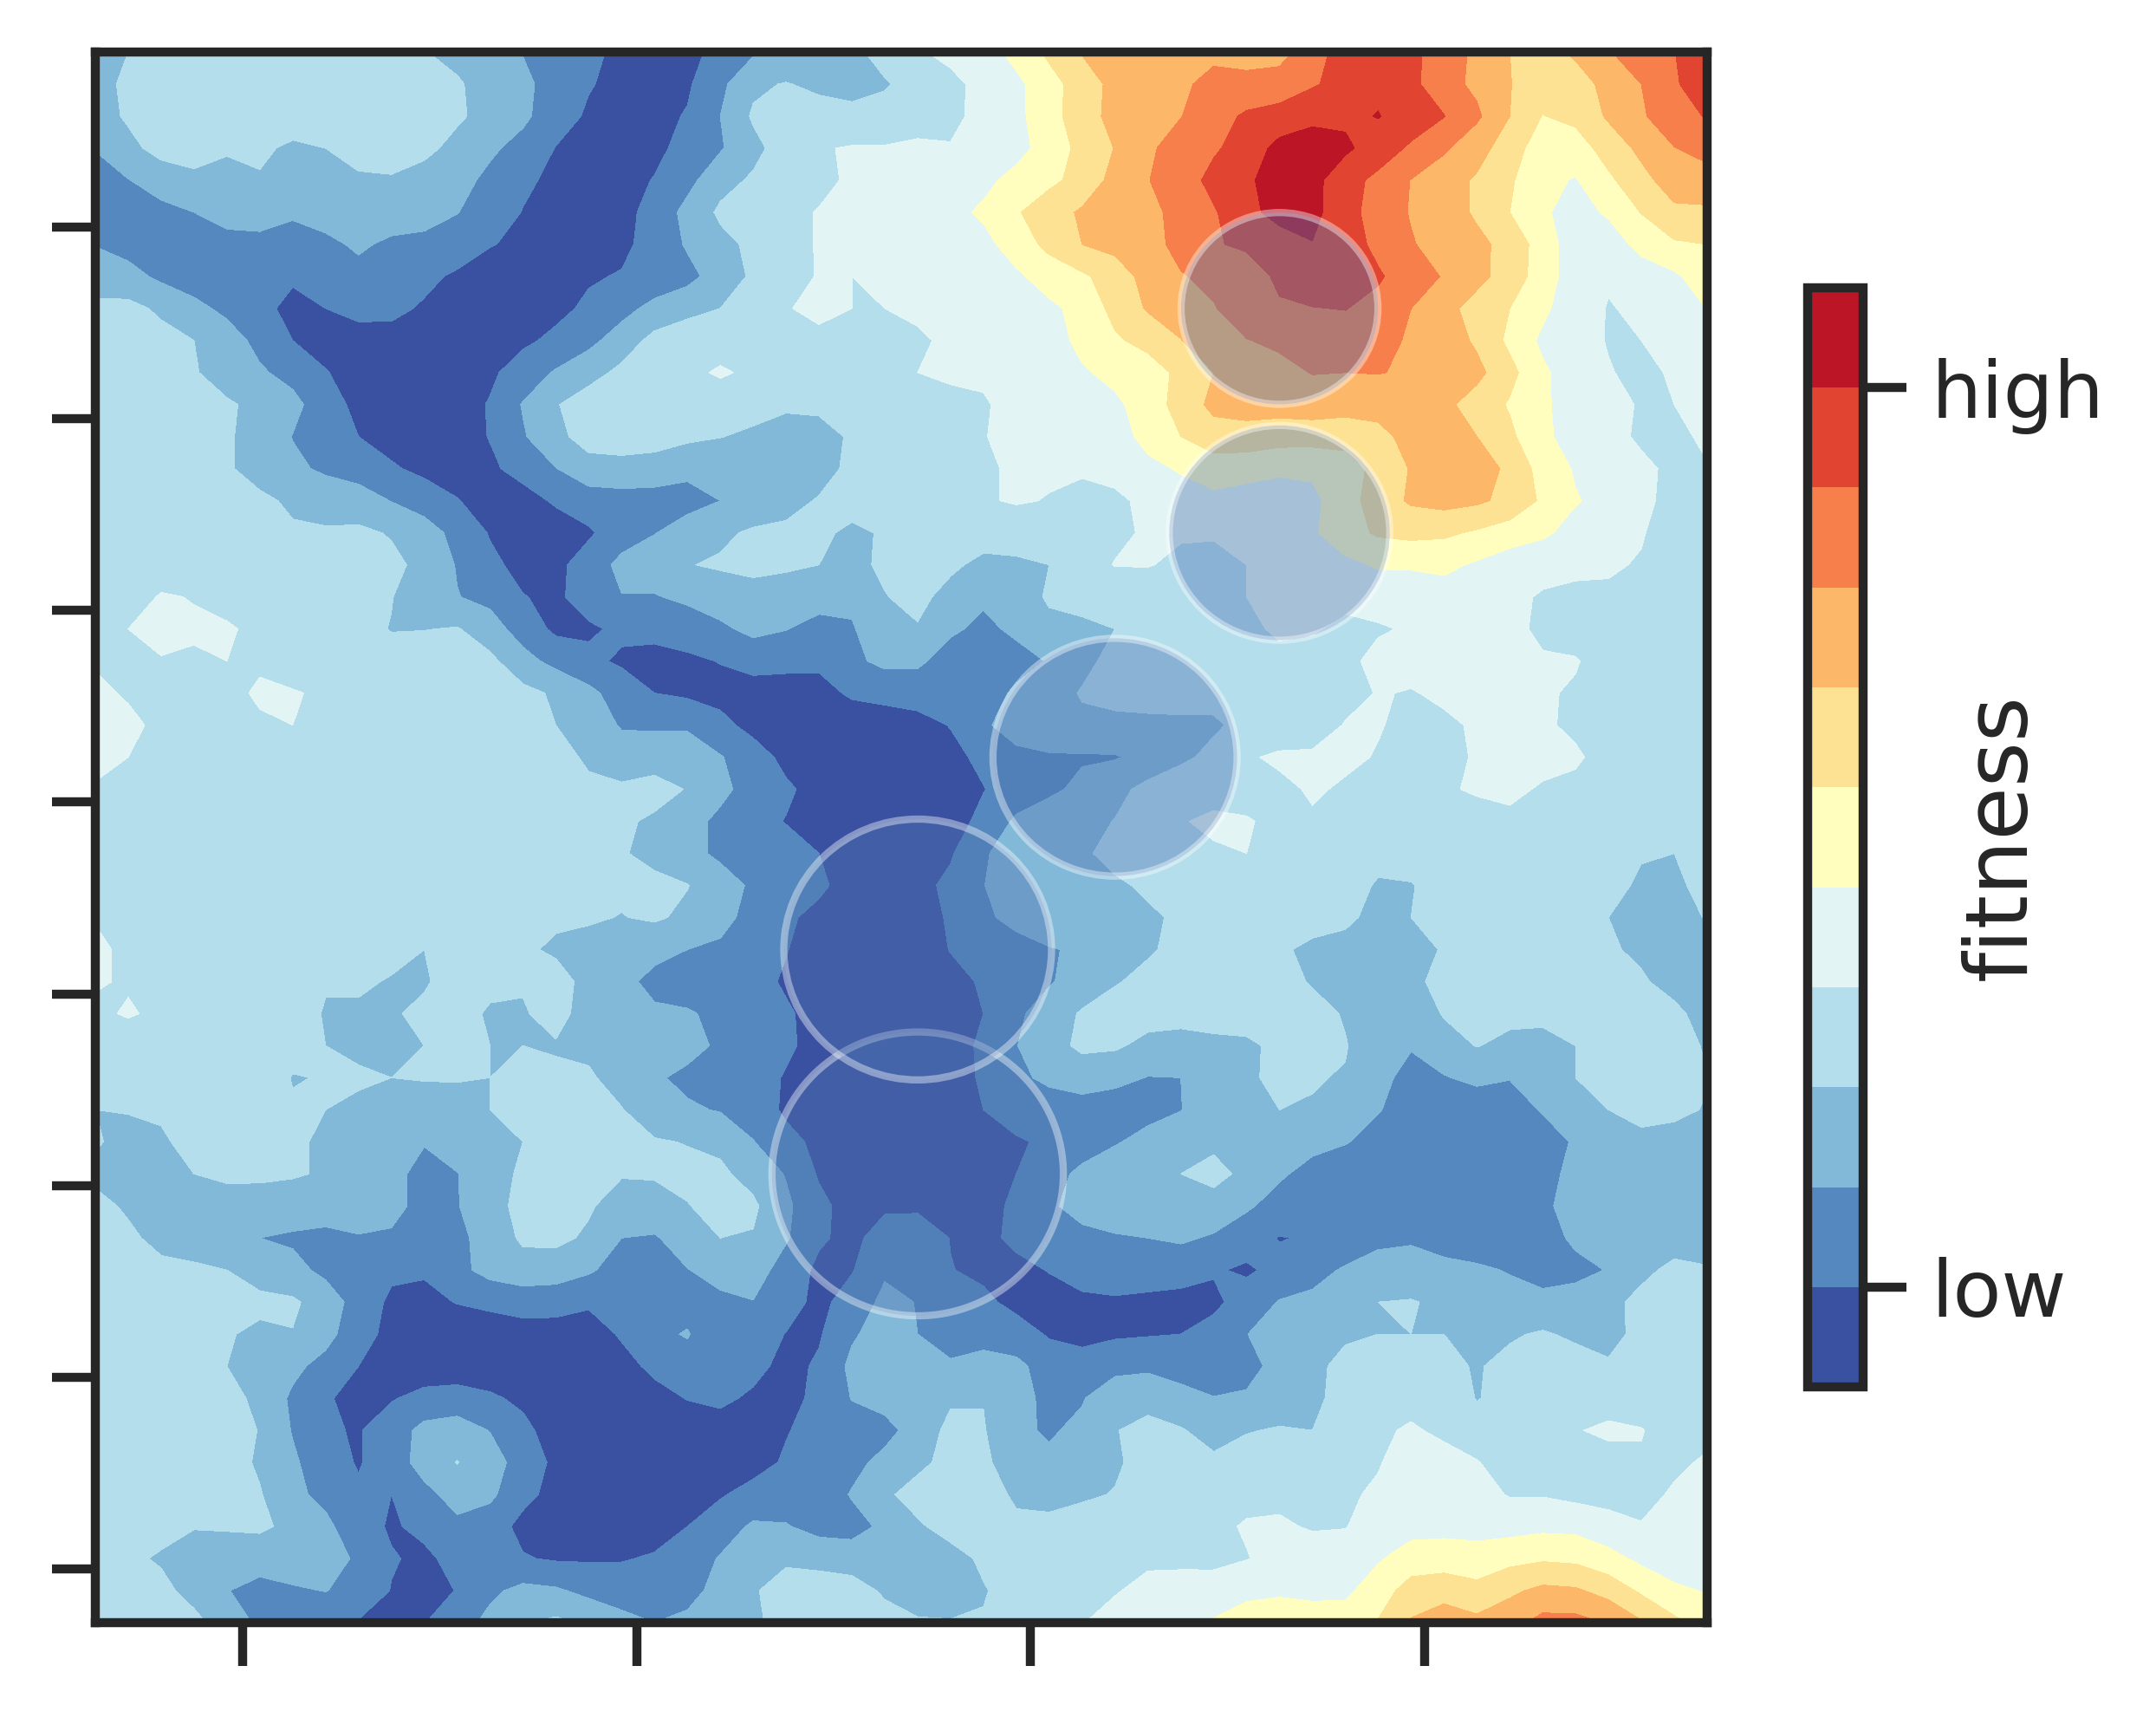

In [861]:
fig=plt.figure(figsize=(5,4),dpi=600)
ax = fig.gca()
cntr = ax.contourf(raw_x, raw_y, raw_z, levels=10, cmap=cm.RdYlBu_r)

cbar=plt.colorbar(cntr, shrink=0.7)

cbar.set_ticks([390,660])
cbar.set_ticklabels(['low','high'])
cbar.set_label('fitness',loc='center',labelpad=-20)

patches=[]
library_size = 0.004
starts_x = [35,28,22,15,8] 
starts_y = [25,25,31,36,36]

for step in range(5):
    left = starts_x[step]
    right = starts_y[step]
    start_point=[raw_x[left,right],raw_y[left,right]]
    library_size -= 0.0003
    
    circle = Circle(start_point, library_size, facecolor=cm.twilight_shifted_r(step/5), alpha=0.4) 
    patches.append(circle) 
    
# add these circles to a collection 
p = PatchCollection(patches, cmap=cm.twilight_shifted_r,alpha = 0.4) 
ax.add_collection(p) 

for step in range(4):

    left = starts_x[step]
    right = starts_y[step]
    start_point=[raw_x[left,right],raw_y[left,right],raw_z[left,right]]

    left = starts_x[step+1]
    right = starts_y[step+1]
    end_point=[raw_x[left,right],raw_y[left,right],raw_z[left,right]]

    xs,ys,zs=list(zip(start_point,end_point))

ax.set_xticklabels('')
ax.set_yticklabels('')

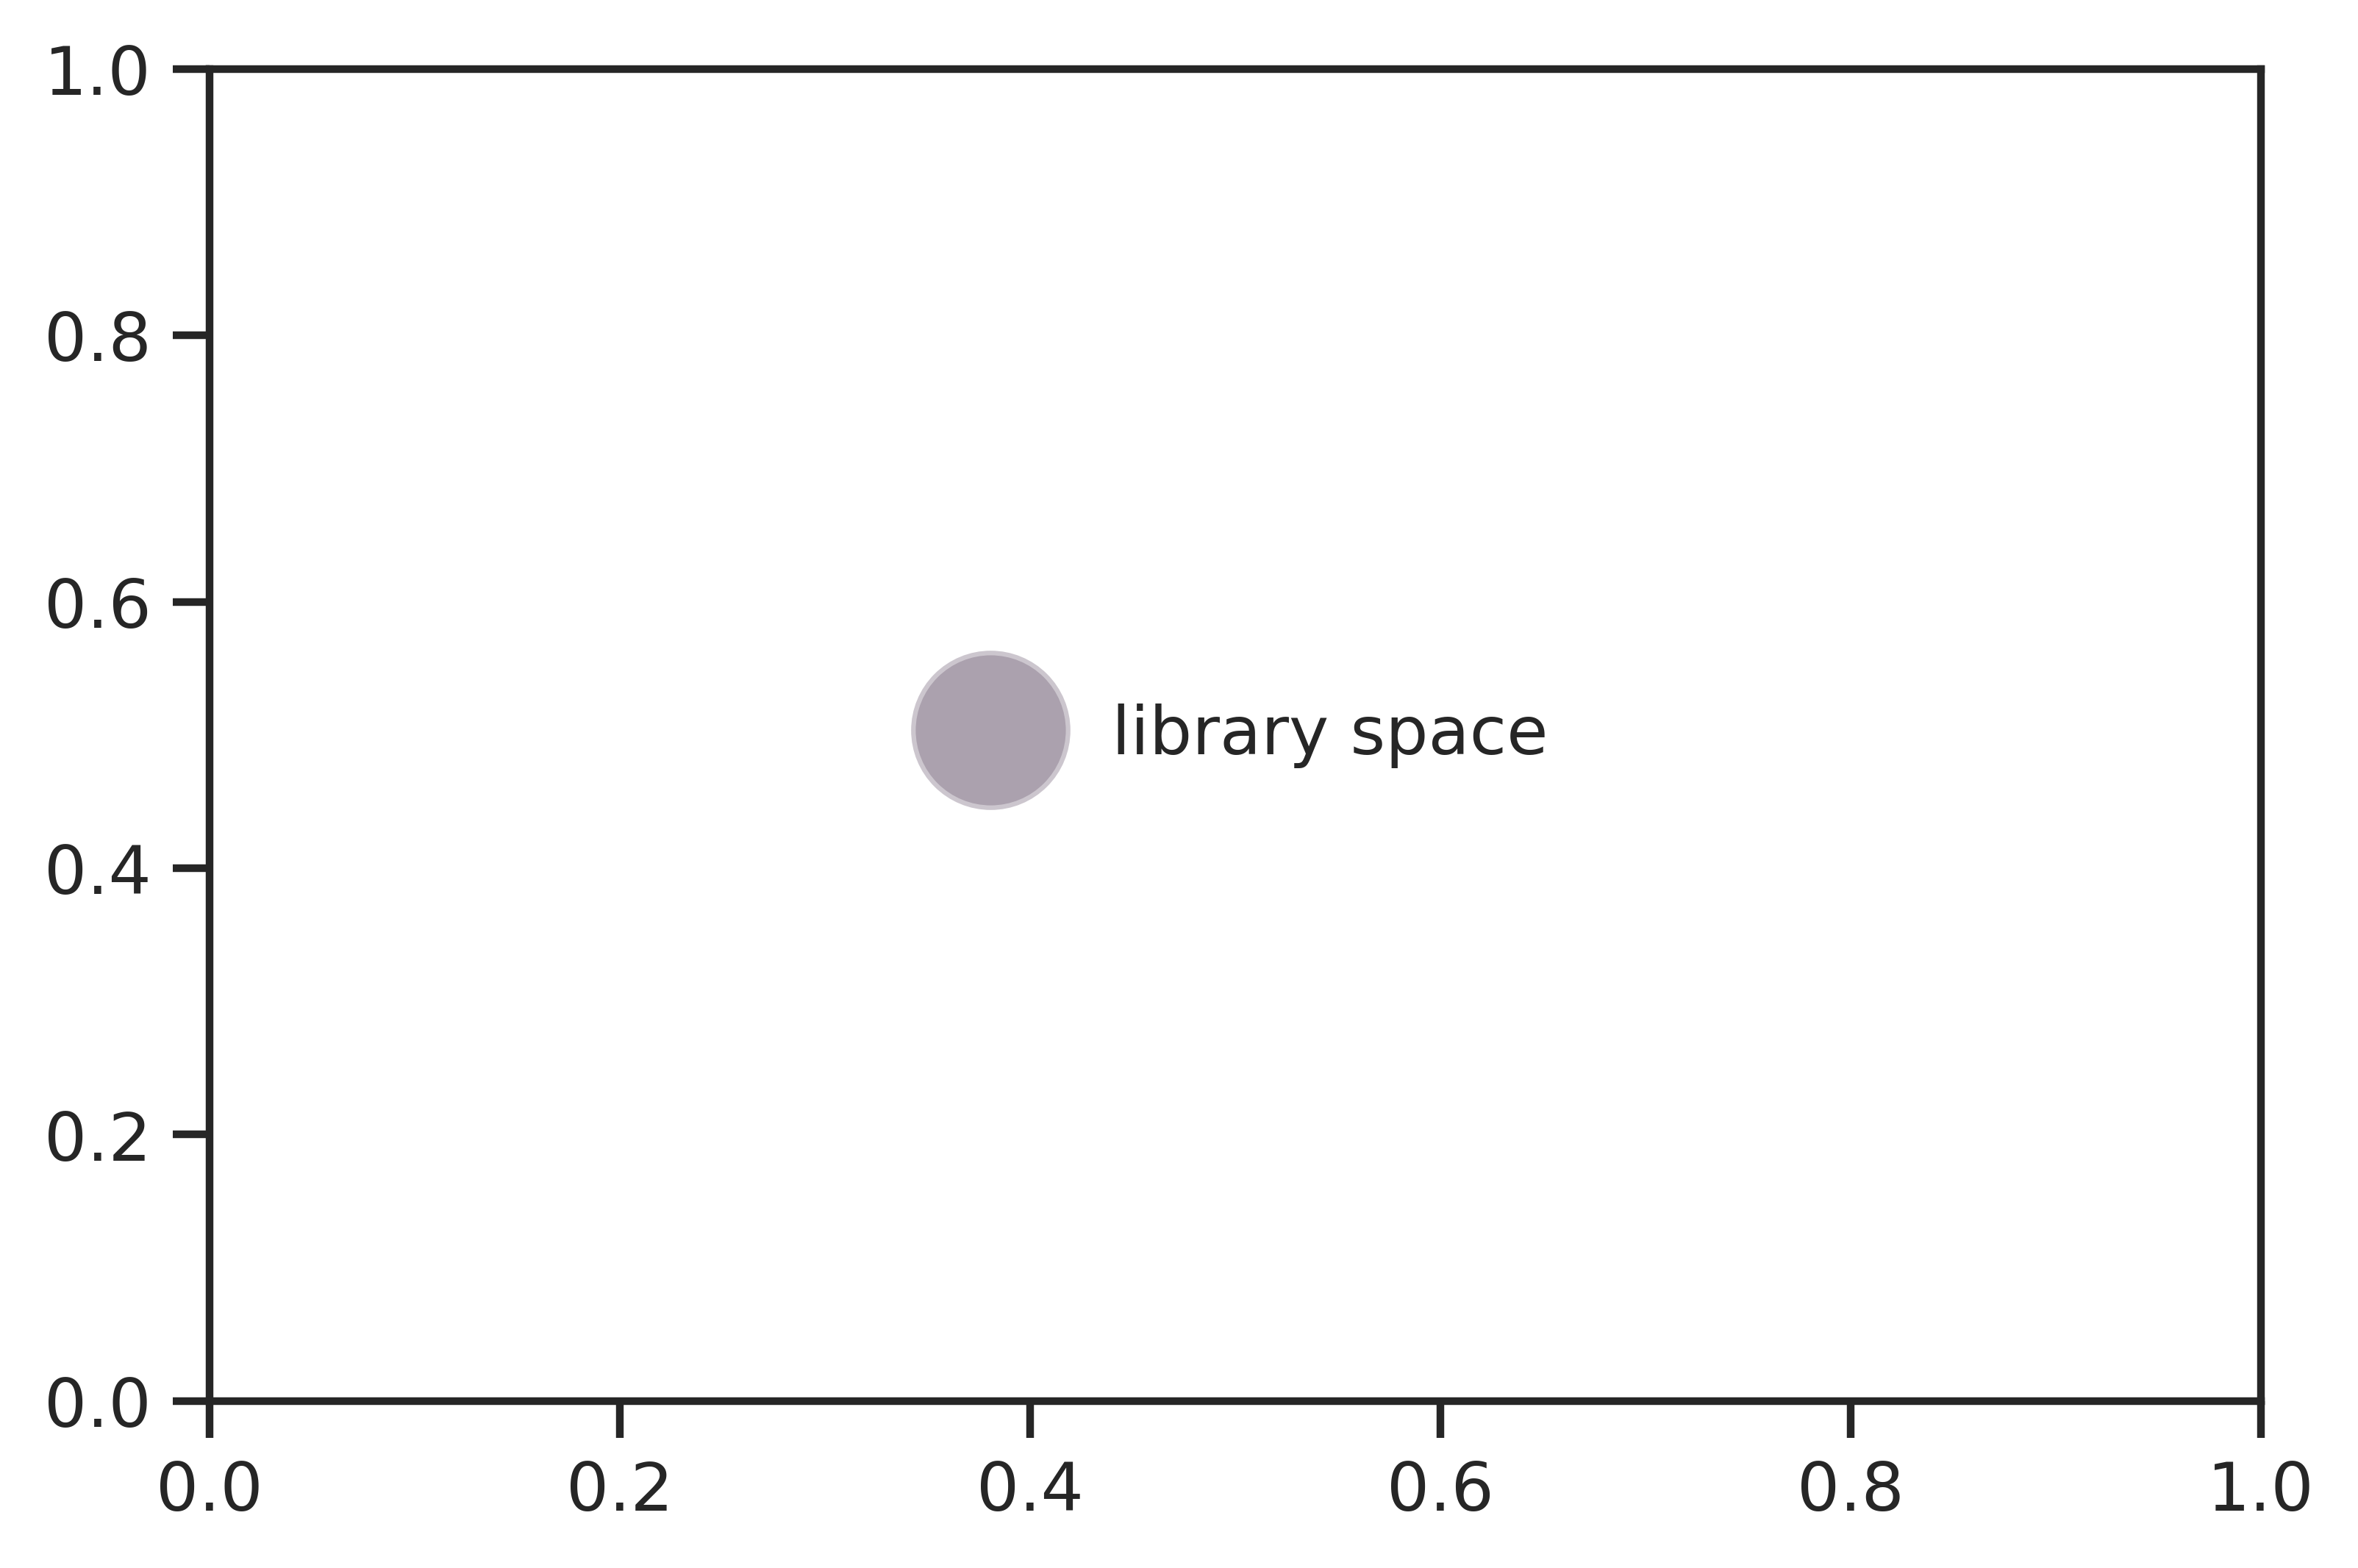

In [627]:
fig,axs=plt.subplots(dpi=600)

from matplotlib.lines import Line2D

handles = []
for i in range(1):
    line = Line2D([], [], label='library space', color='white', linewidth=1.5, marker='o', alpha=0.4,
                  markerfacecolor=cm.twilight_shifted_r((i/5)), markeredgewidth=1.5, markersize=26)
    handles.append(line)
plt.legend(handles=handles, scatterpoints=5, frameon=False, loc='center')

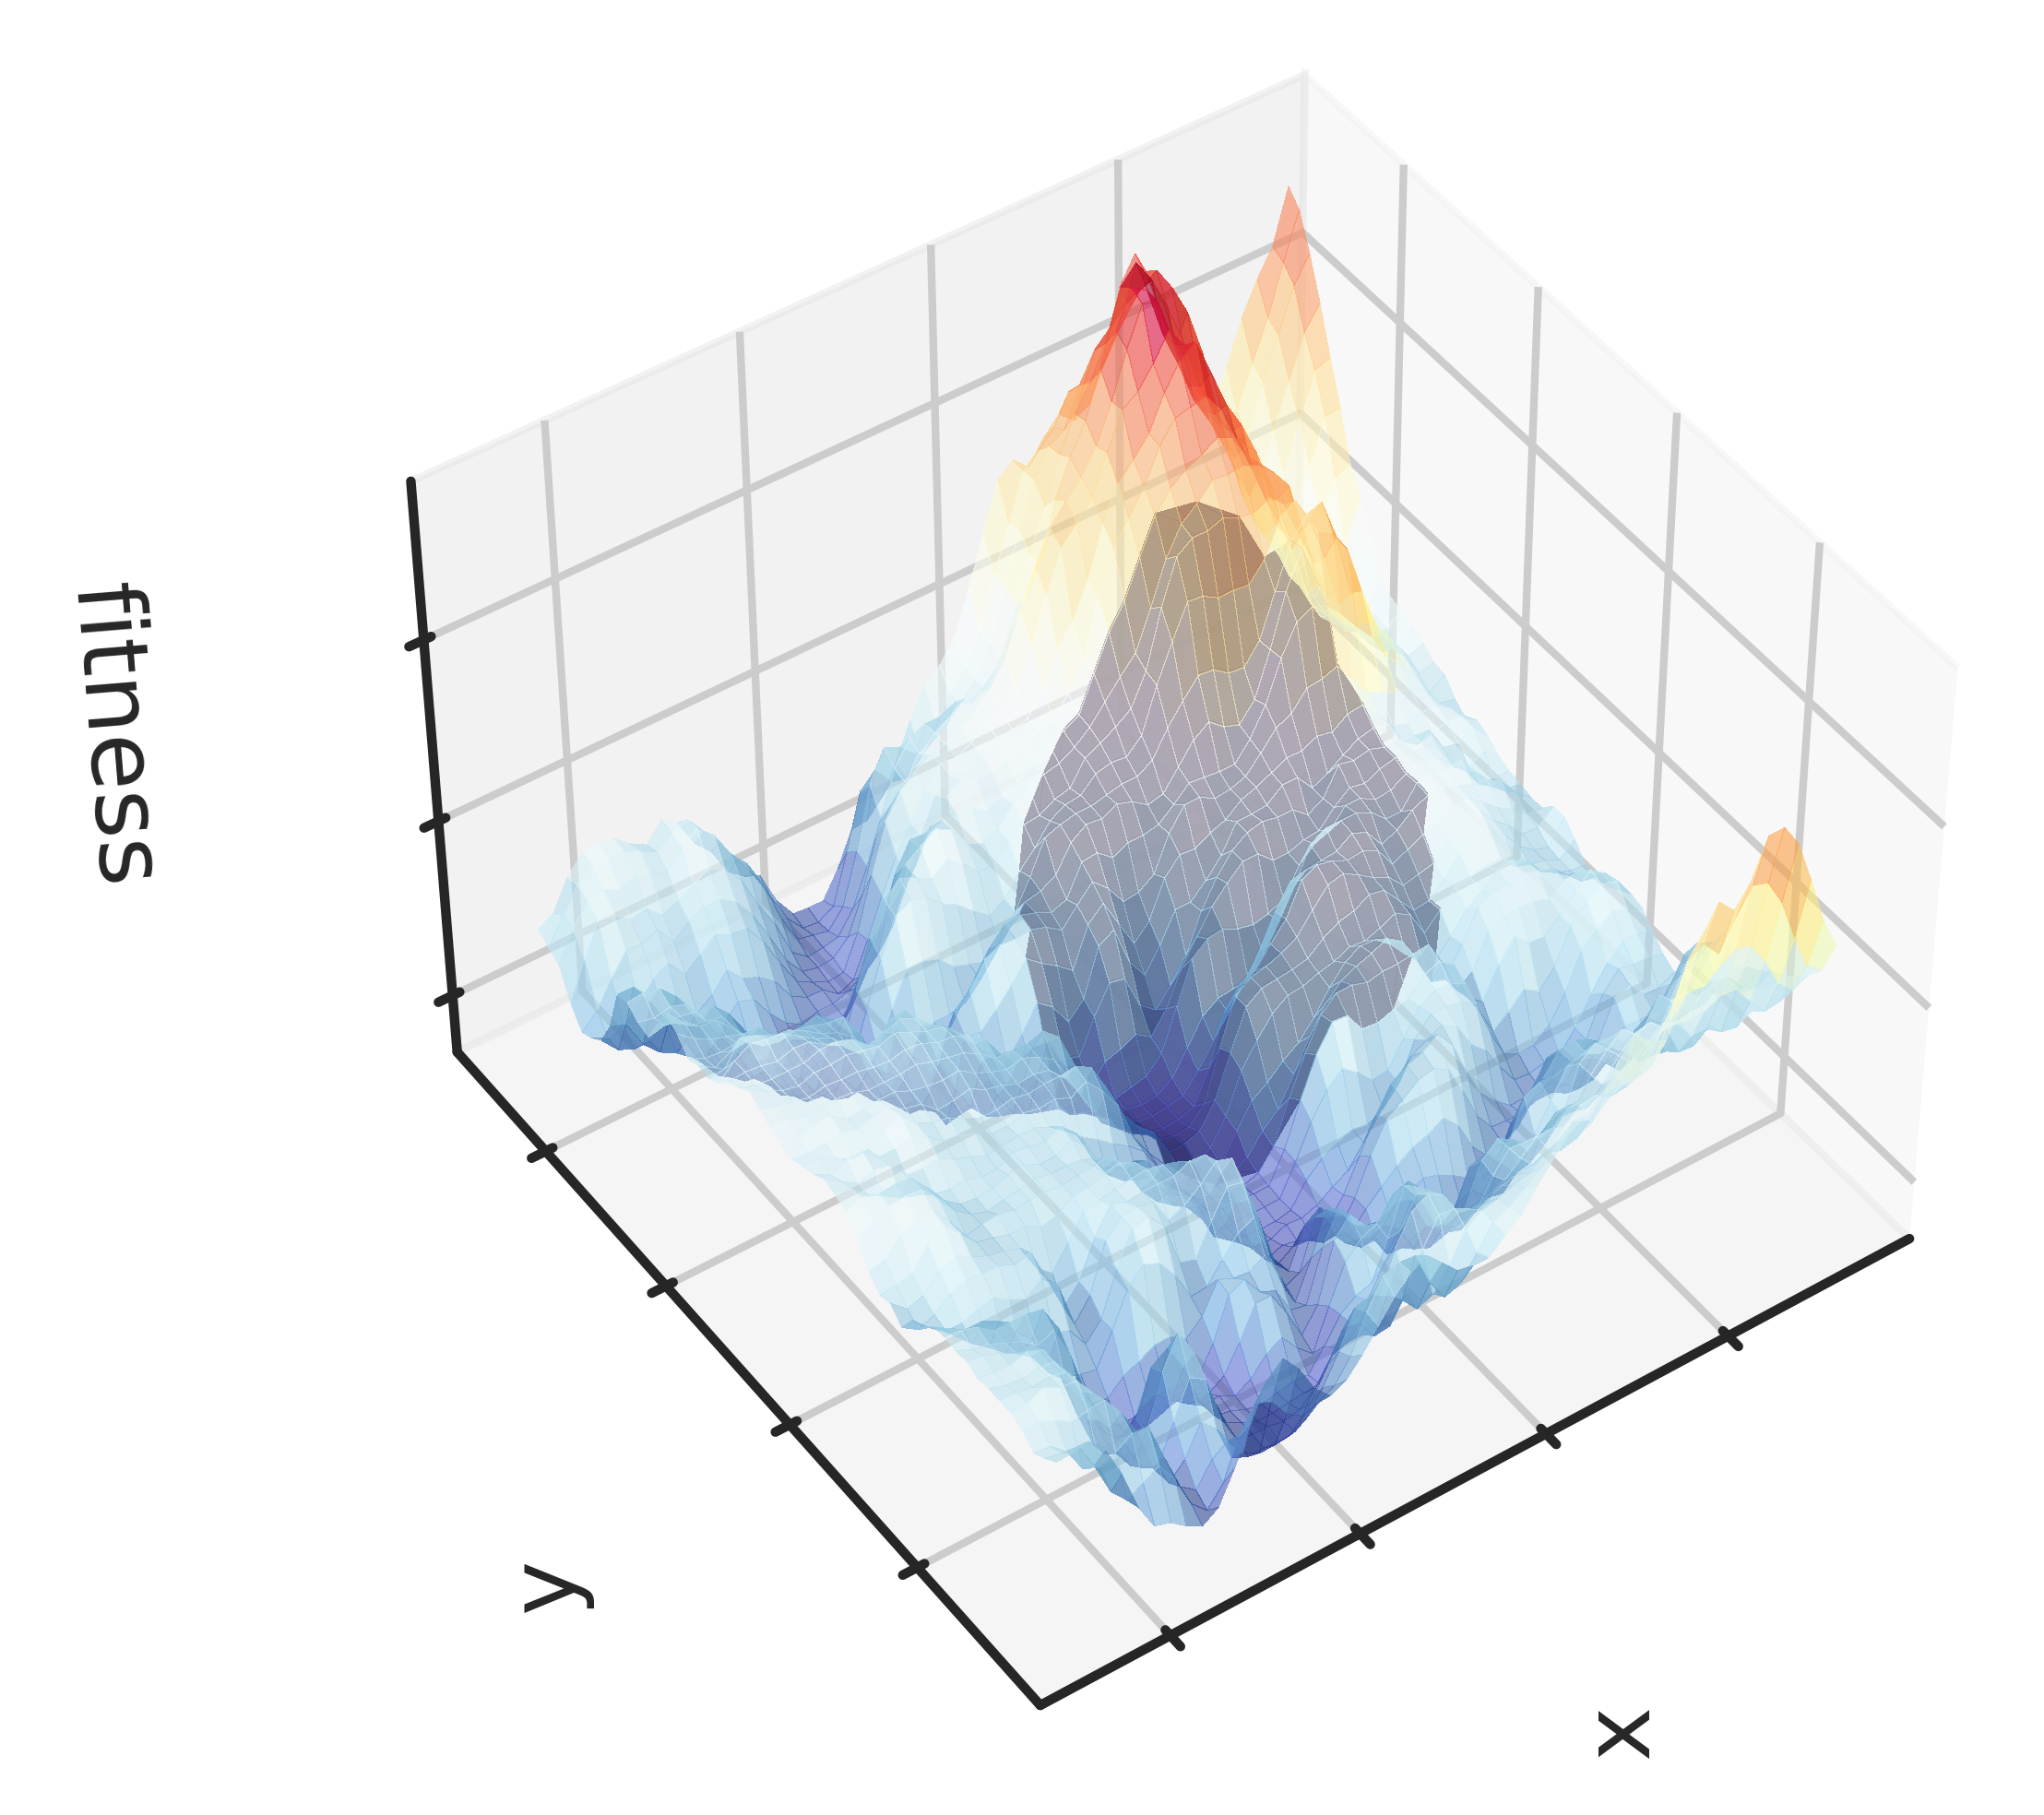

In [707]:
# Set up plot
fig, ax = plt.subplots(dpi=600,subplot_kw=dict(projection='3d'))



# ====================== global landscpe ===========================

ls = LightSource(-125, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(raw_z, cmap=cm.RdYlBu_r, vert_exag=0.1, blend_mode='soft')

# surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=False)

surf = ax.plot_surface(raw_x, raw_y, raw_z, linewidth=0, facecolors=rgb, alpha=0.6,
                       rcount=100, ccount=100 , # maximal number of dots in the surface
                       antialiased=False, shade=False)

# ax.scatter(raw_x[21,15], raw_y[21,15],raw_z[21,15],s=10,color='black' )

ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_zticklabels('')

ax.set_xlabel('x',rotation=90)

ax.set_ylabel('y',rotation=90)

ax.set_zlabel('fitness',rotation=90)



# ======================= stepwise searching ====================== 

# 5 libraries
library_size = 0.010
starts_x = [20] 
starts_y = [31]
           

for step in range(1):
    
    # center of the circle
    left = starts_x[step]
    right = starts_y[step]
    start_point=[raw_x[left,right],raw_y[left,right]]
    library_size -= 0.0003
    
    color = cm.twilight_shifted_r((step)/5)
    
    # coord
    X_incircle_coords, Y_incircle_coords, Z_incircle_coords = fetch_corcords_in_circle(library_size, start_point)
    ax.plot_surface(X_incircle_coords, Y_incircle_coords, Z_incircle_coords+1, alpha=0.9,
                       linewidth=0,  antialiased=False, shade=False, color=color);


# for step in range(4):
    
#     left = starts_x[step]
#     right = starts_y[step]
#     start_point=[raw_x[left,right],raw_y[left,right],raw_z[left,right]]
    
#     left = starts_x[step+1]
#     right = starts_y[step+1]
#     end_point=[raw_x[left,right],raw_y[left,right],raw_z[left,right]]
    
#     xs,ys,zs=list(zip(start_point,end_point))
#     arw = Arrow3D(xs,ys,np.array(zs)+30, arrowstyle="->",
#                   color= 'red', lw =0.5, mutation_scale=10)
#     ax.add_artist(arw)




ax.view_init(45,-125)
plt.show()

[Text(0, 36.68, ''),
 Text(0, 36.685, ''),
 Text(0, 36.69, ''),
 Text(0, 36.695, ''),
 Text(0, 36.7, ''),
 Text(0, 36.705, ''),
 Text(0, 36.71, ''),
 Text(0, 36.715, ''),
 Text(0, 36.72, ''),
 Text(0, 36.725, '')]

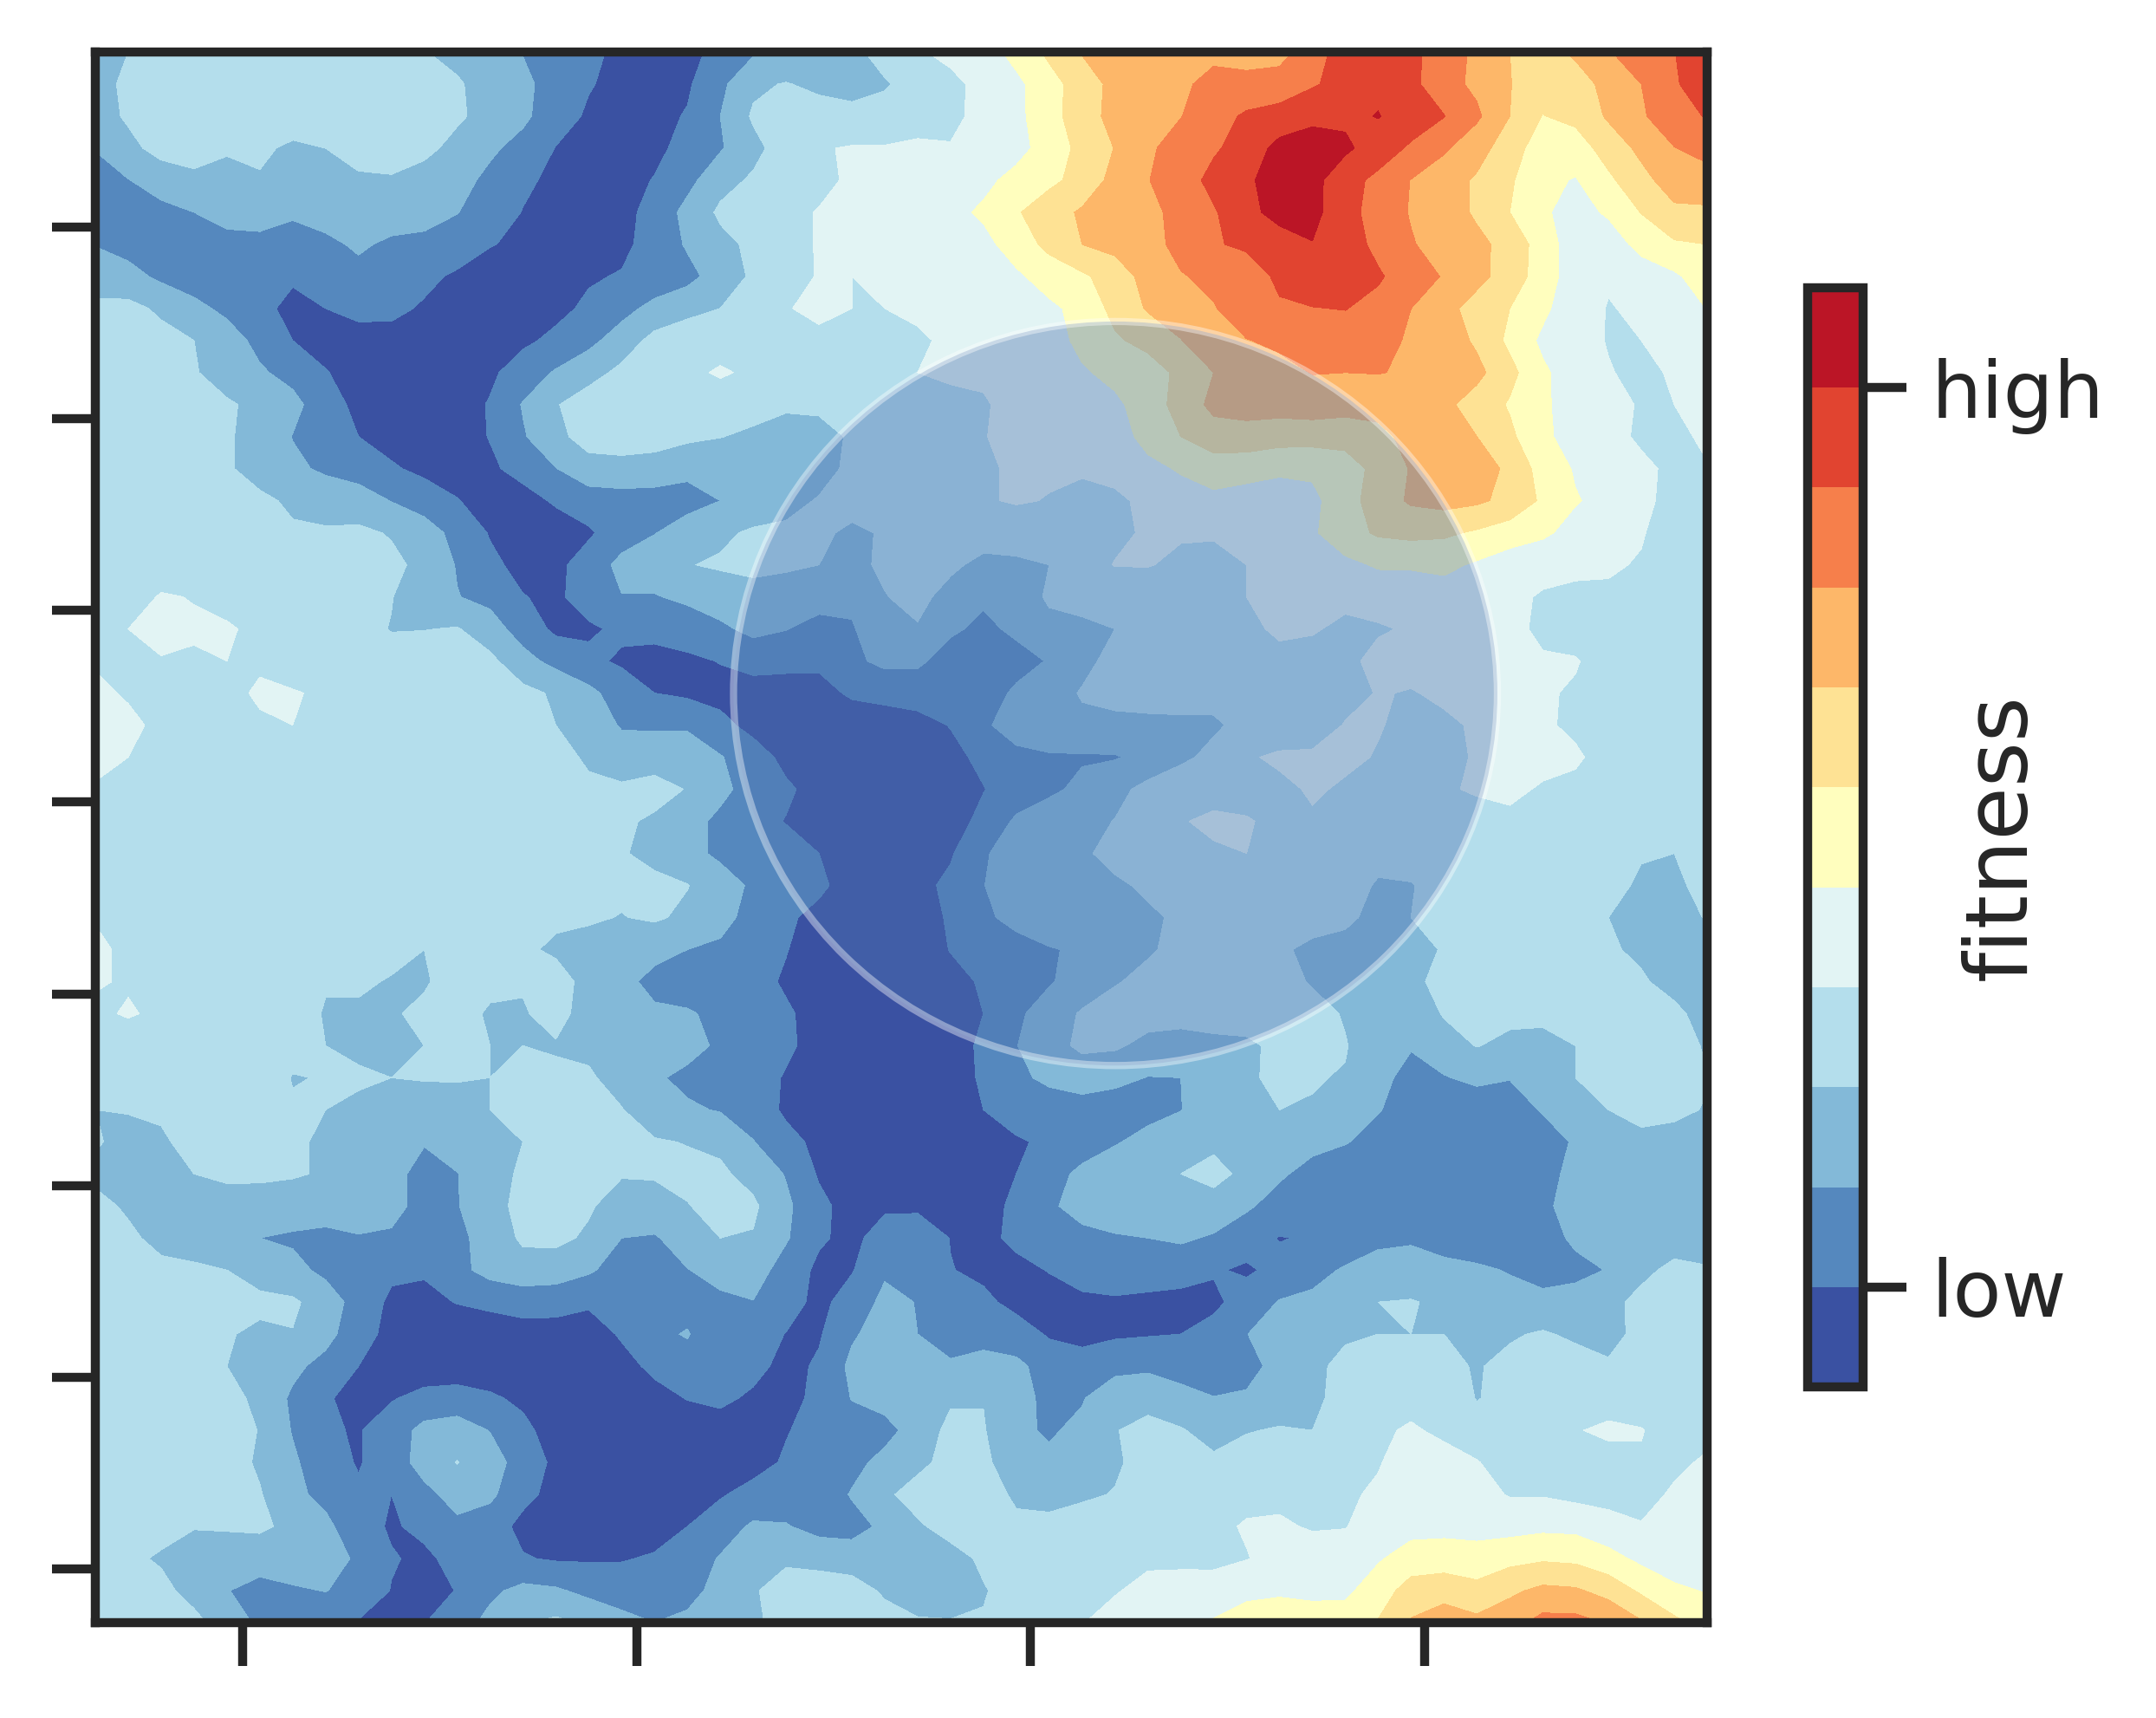

In [704]:
fig=plt.figure(figsize=(5,4),dpi=600)
ax = fig.gca()
cntr = ax.contourf(raw_x, raw_y, raw_z, levels=10, cmap=cm.RdYlBu_r)

cbar=plt.colorbar(cntr, shrink=0.7)

cbar.set_ticks([390,660])
cbar.set_ticklabels(['low','high'])
cbar.set_label('fitness',loc='center',labelpad=-20)

patches=[]
library_size = 0.010
starts_x = [20] 
starts_y = [31]

for step in range(1):
    left = starts_x[step]
    right = starts_y[step]
    start_point=[raw_x[left,right],raw_y[left,right]]
    library_size -= 0.0003
    
    circle = Circle(start_point, library_size, facecolor=cm.twilight_shifted_r(step/5), alpha=0.4) 
    patches.append(circle) 
    
# add these circles to a collection 
p = PatchCollection(patches, cmap=cm.twilight_shifted_r,alpha = 0.4) 
ax.add_collection(p) 


ax.set_xticklabels('')
ax.set_yticklabels('')

## compute area

In [669]:
number_of_hist = lambda Z,threshold : np.sum(Z_incircle_coords > threshold)

In [854]:
library_size = 0.01
random_library_area = (library_size*1000)**2
left = 22
right = 31
           
start_point=[raw_x[left,right],raw_y[left,right]]# circle center

X_incircle_coords, Y_incircle_coords, Z_incircle_coords = fetch_corcords_in_circle(library_size, start_point)

random_n_points = np.power(X_incircle_coords.shape[0],2)

random_n_hits = (number_of_hist(Z_incircle_coords,500),number_of_hist(Z_incircle_coords,600))

In [855]:
random_n_hits

(52, 0)

In [905]:
library_size = 0.004
starts_x = [35,28,22,15,8] 
starts_y = [25,25,31,36,36]
libray_area = []
n_points = []
n_hits = []

for step in range(5):
    left = starts_x[step]
    right = starts_y[step]
    start_point=[raw_x[left,right],raw_y[left,right]]
    library_size -= 0.0003
    libray_area.append((library_size*1000)**2)
    X_incircle_coords, Y_incircle_coords, Z_incircle_coords = fetch_corcords_in_circle(library_size, start_point)
    
    n_points.append(np.power(X_incircle_coords.shape[0],2))
    n_hits.append( [number_of_hist(Z_incircle_coords,500),number_of_hist(Z_incircle_coords,600)] )

In [906]:
np.sum(n_hits,axis=0)

array([48, 18])

In [910]:
random_libaray_cumu = [random_n_points-78-6,78,6]
acitve_libaray_cumu = [np.sum(n_points)-42-13,48,18]

In [911]:
acitve_npoints=np.sum(n_points) 

/tmp/ipykernel_2404758/656670800.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['random libaray', 'active learning library'])


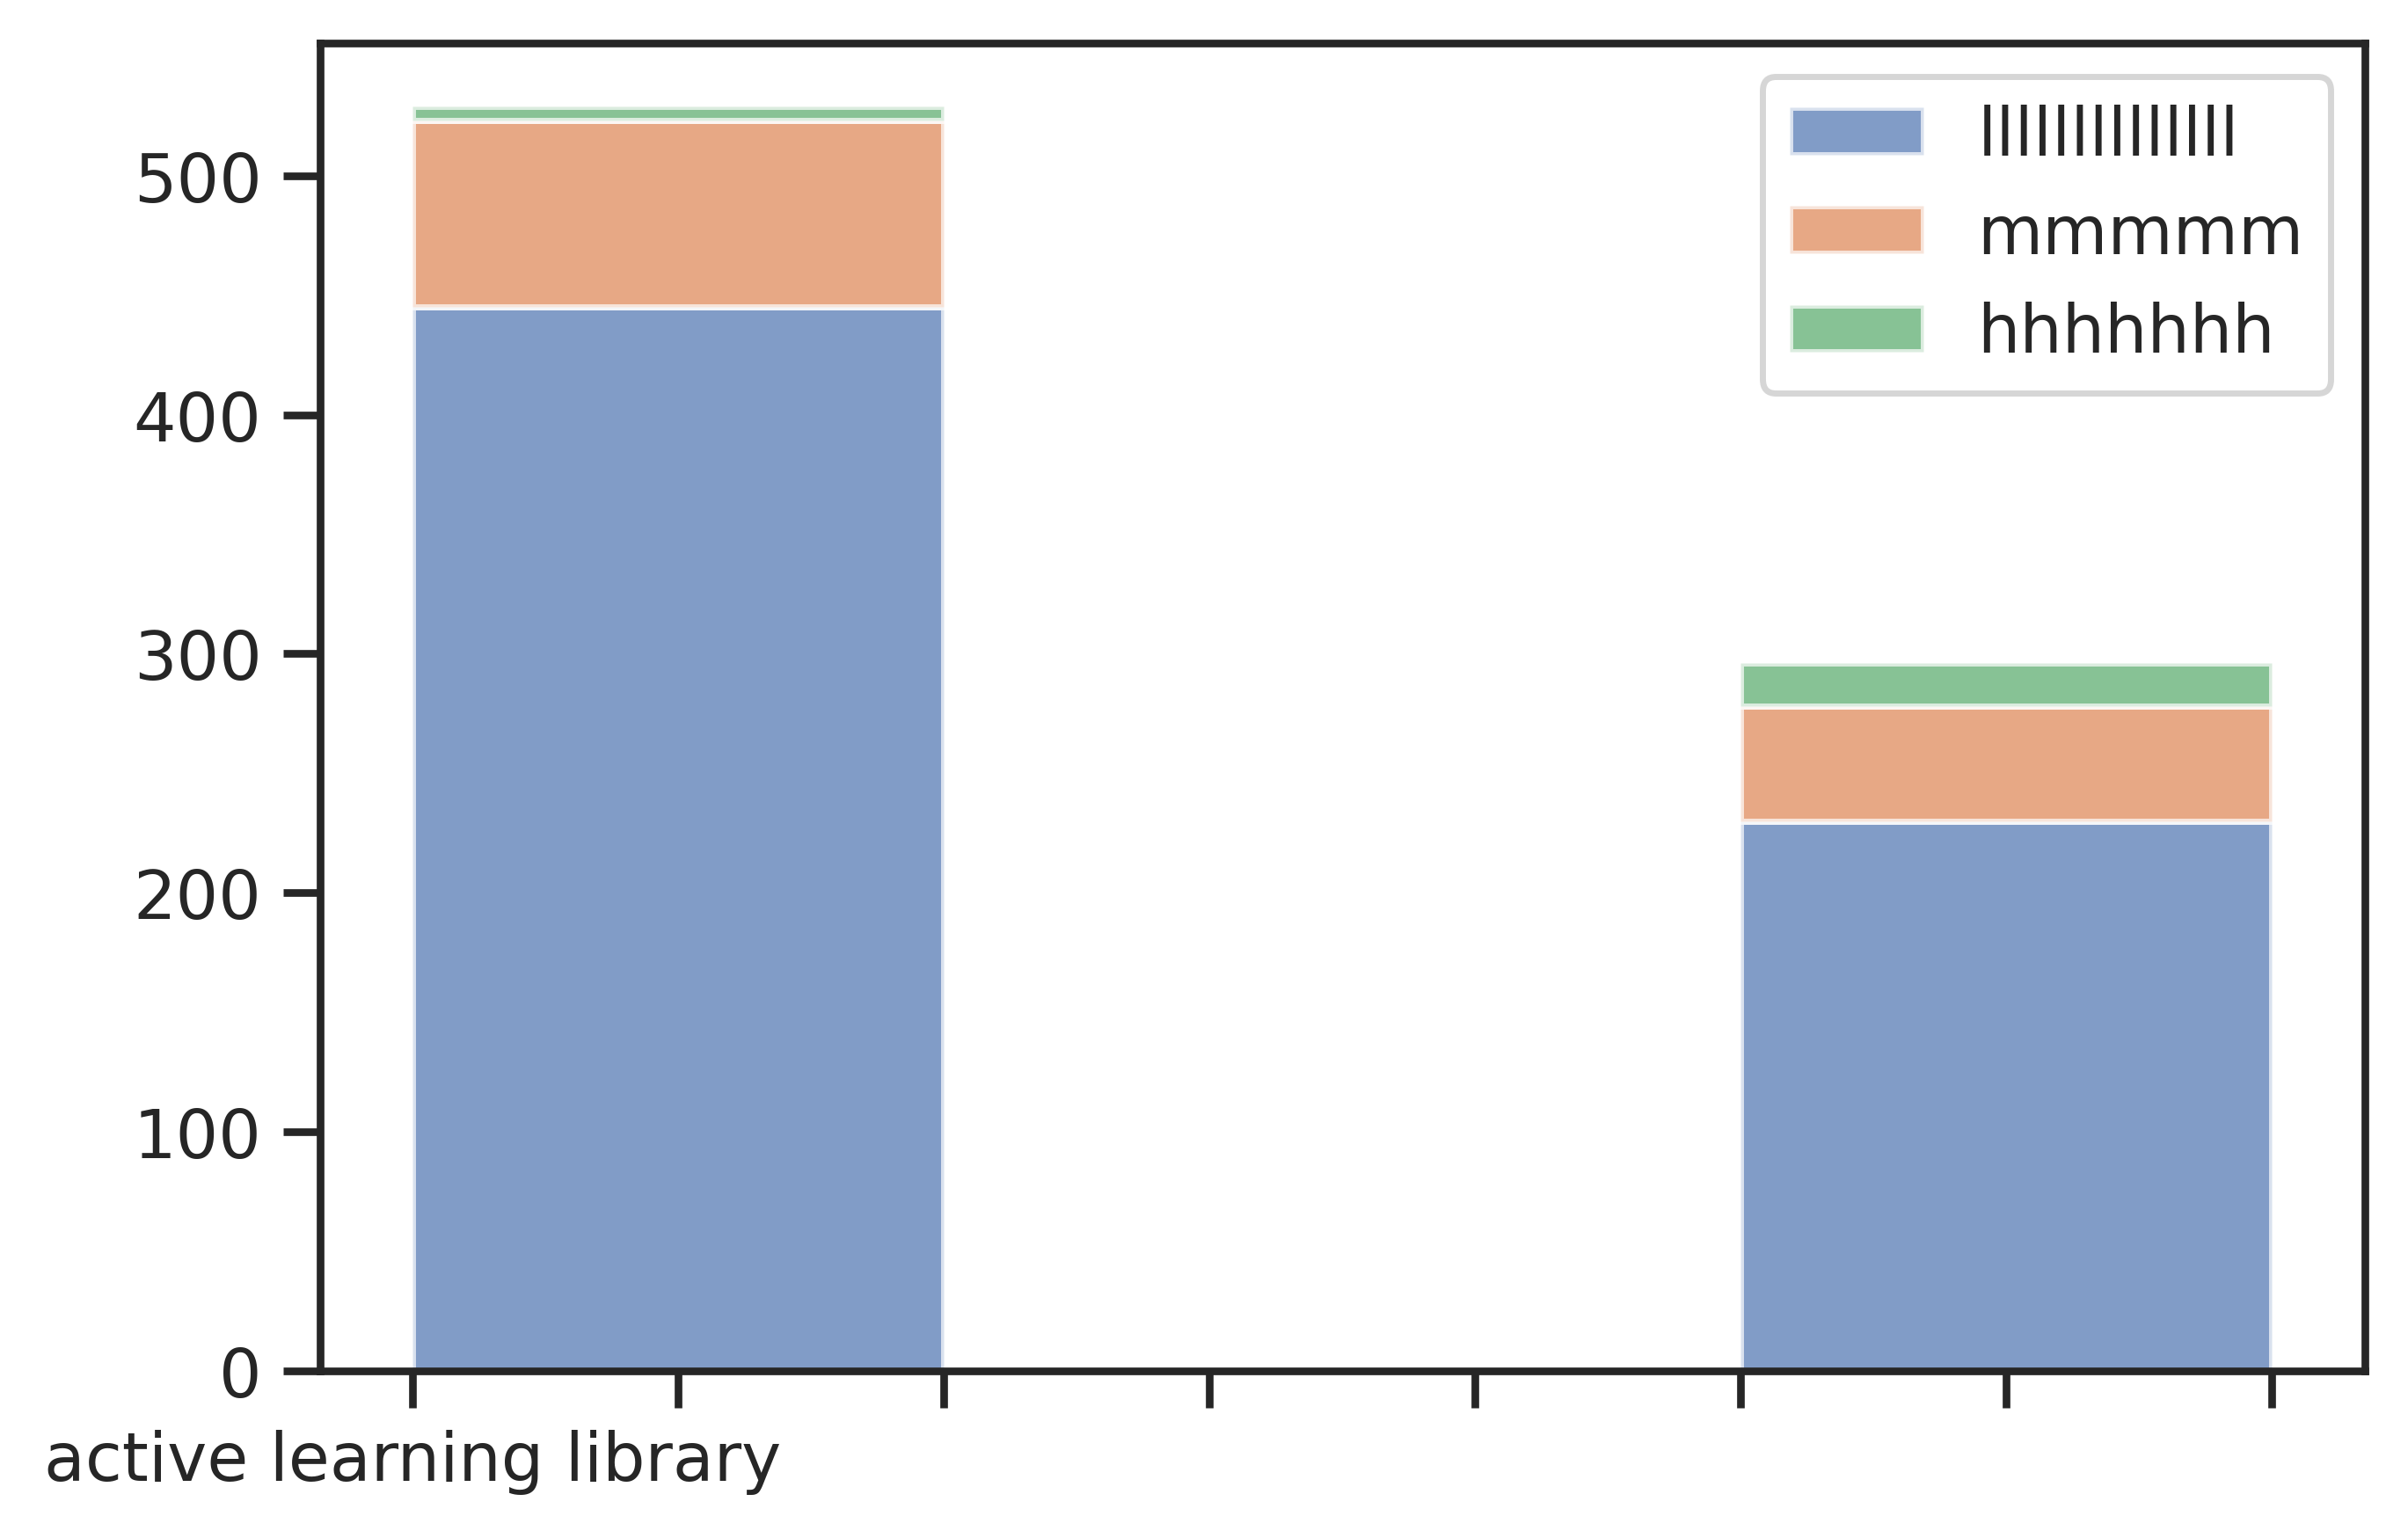

In [917]:
fig,ax = plt.subplots(1,1,dpi=500)
bottom = np.array([0,0])

labels = ['llllllllllllll','mmmmm','hhhhhhh']
i=0
for height in zip(random_libaray_cumu,acitve_libaray_cumu):    
    ax.bar([0,1],height=height, bottom= bottom,width=0.4, alpha=0.7, label='%s'%labels[i])
    bottom += np.array(height) 
    i+=1
ax.set_xticklabels(['random libaray', 'active learning library'])
ax.legend()

In [868]:
n_hits

[[0, 0], [0, 0], [0, 0], [23, 0], [25, 18]]

In [869]:
n_hits.append([78,6])
active_lib = pd.DataFrame(n_hits,columns=['median_fitness','high_fitness'])

active_lib.loc[:,'library'] = ['1st_act','2nd_act','3rd_act','4th_act','5th_act','random_lib']

In [870]:
act_sns_df=pd.melt(active_lib.iloc[0:5], id_vars='library',var_name='fit_region')

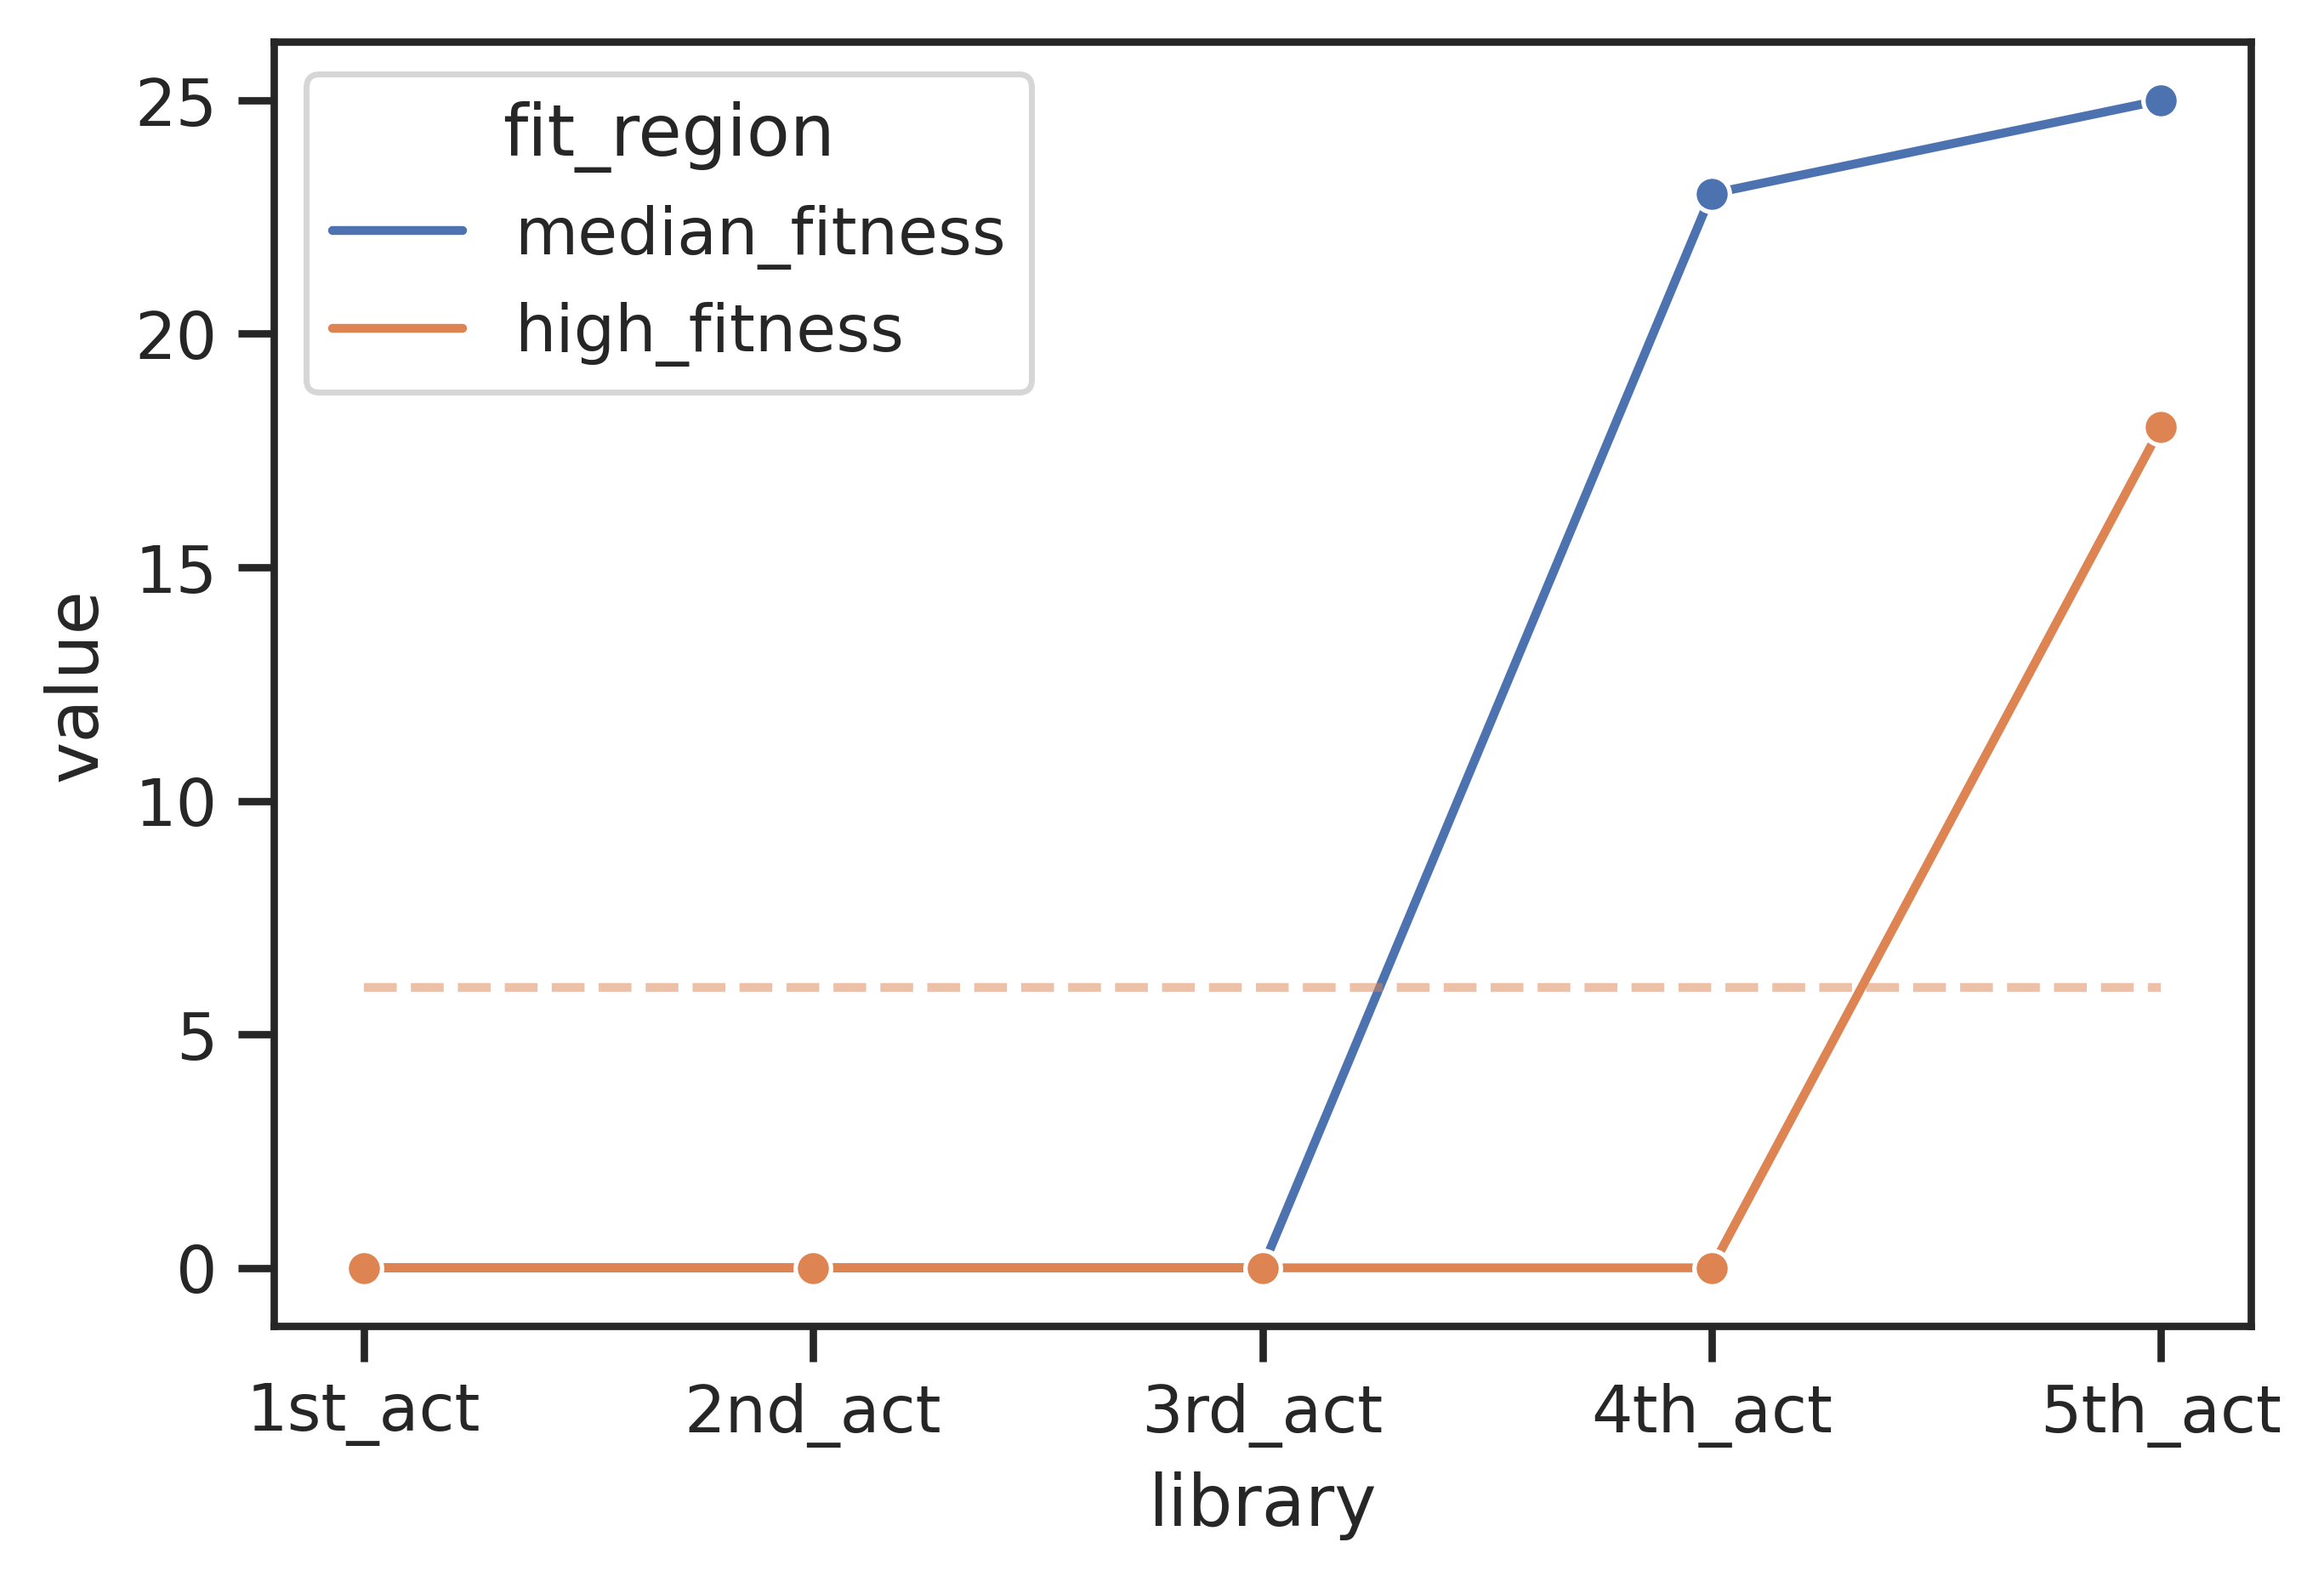

In [871]:
fig,ax = plt.subplots(1,1,dpi=500)
sns.lineplot(data=act_sns_df, x = 'library', hue = 'fit_region', y='value',ax=ax, marker='o')
# ax.plot([0,5],[78,78],'--', alpha=0.5, label='random_median')
ax.plot([0,4],[6,6],'--', alpha=0.5, label='random_high')

In [884]:
total_hits = [np.sum(n_hits[:-1],axis=0).tolist() + [np.sum(n_hits[:-1])]]

In [885]:
total_hits

[[48, 18, 66]]

In [886]:
total_hits.append([78,6,84])

In [887]:
df = pd.DataFrame(total_hits, columns=['median_fitness','high_fitness','desired_fitness'])
df.loc[:,'library'] = ['active_lib','random_lib']

In [888]:
df['libaray_size'] = [acitve_npoints]+[random_n_points]

In [889]:
efficency_df = pd.melt(df, id_vars=['library','libaray_size'])
efficency_df['efficency'] = efficency_df['value'] / efficency_df['libaray_size']

In [890]:
efficency_df

,library,libaray_size,variable,value,efficency
0,active_lib,285,median_fitness,48,0.168421
1,random_lib,529,median_fitness,78,0.147448
2,active_lib,285,high_fitness,18,0.063158
3,random_lib,529,high_fitness,6,0.011342
4,active_lib,285,desired_fitness,66,0.231579
5,random_lib,529,desired_fitness,84,0.158790


<AxesSubplot:xlabel='variable', ylabel='efficency'>

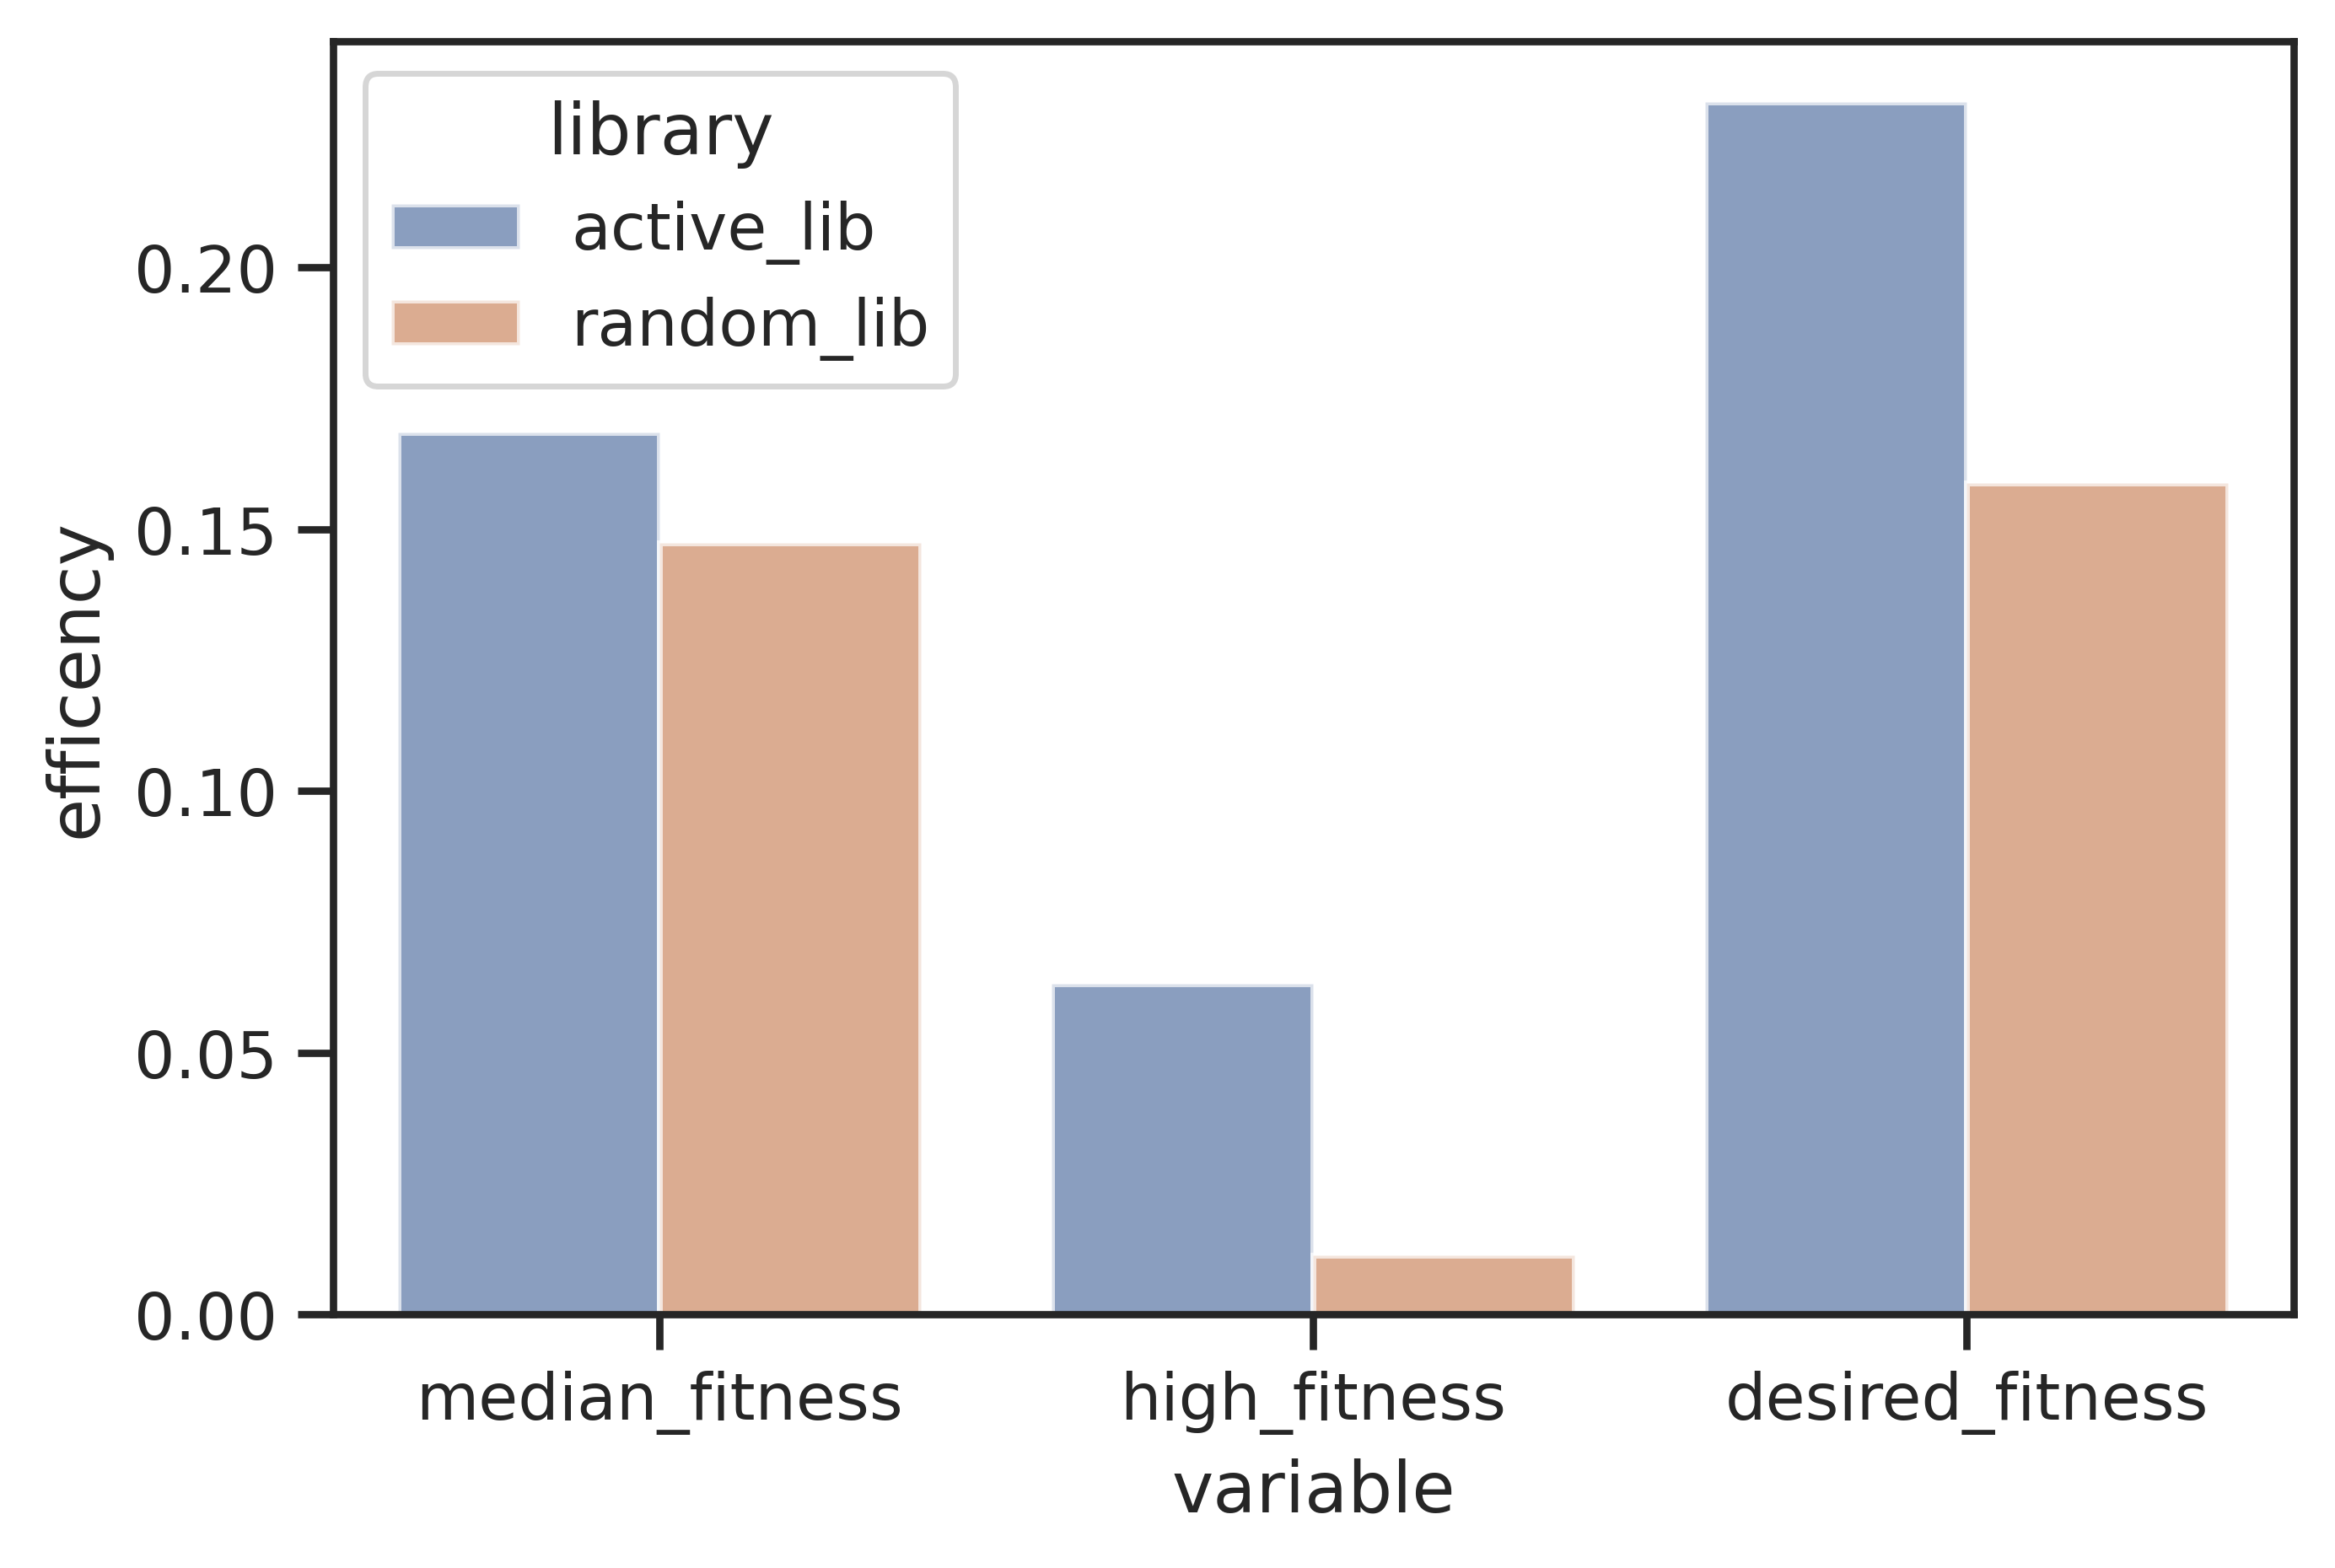

In [904]:
sns.set_theme(style='ticks',palette='deep')
fig,ax = plt.subplots(1,1,dpi=500)

sns.barplot(data=efficency_df, x = 'variable', y='efficency',hue='library',ax=ax,alpha=0.7)

Text(0, 0.5, '')

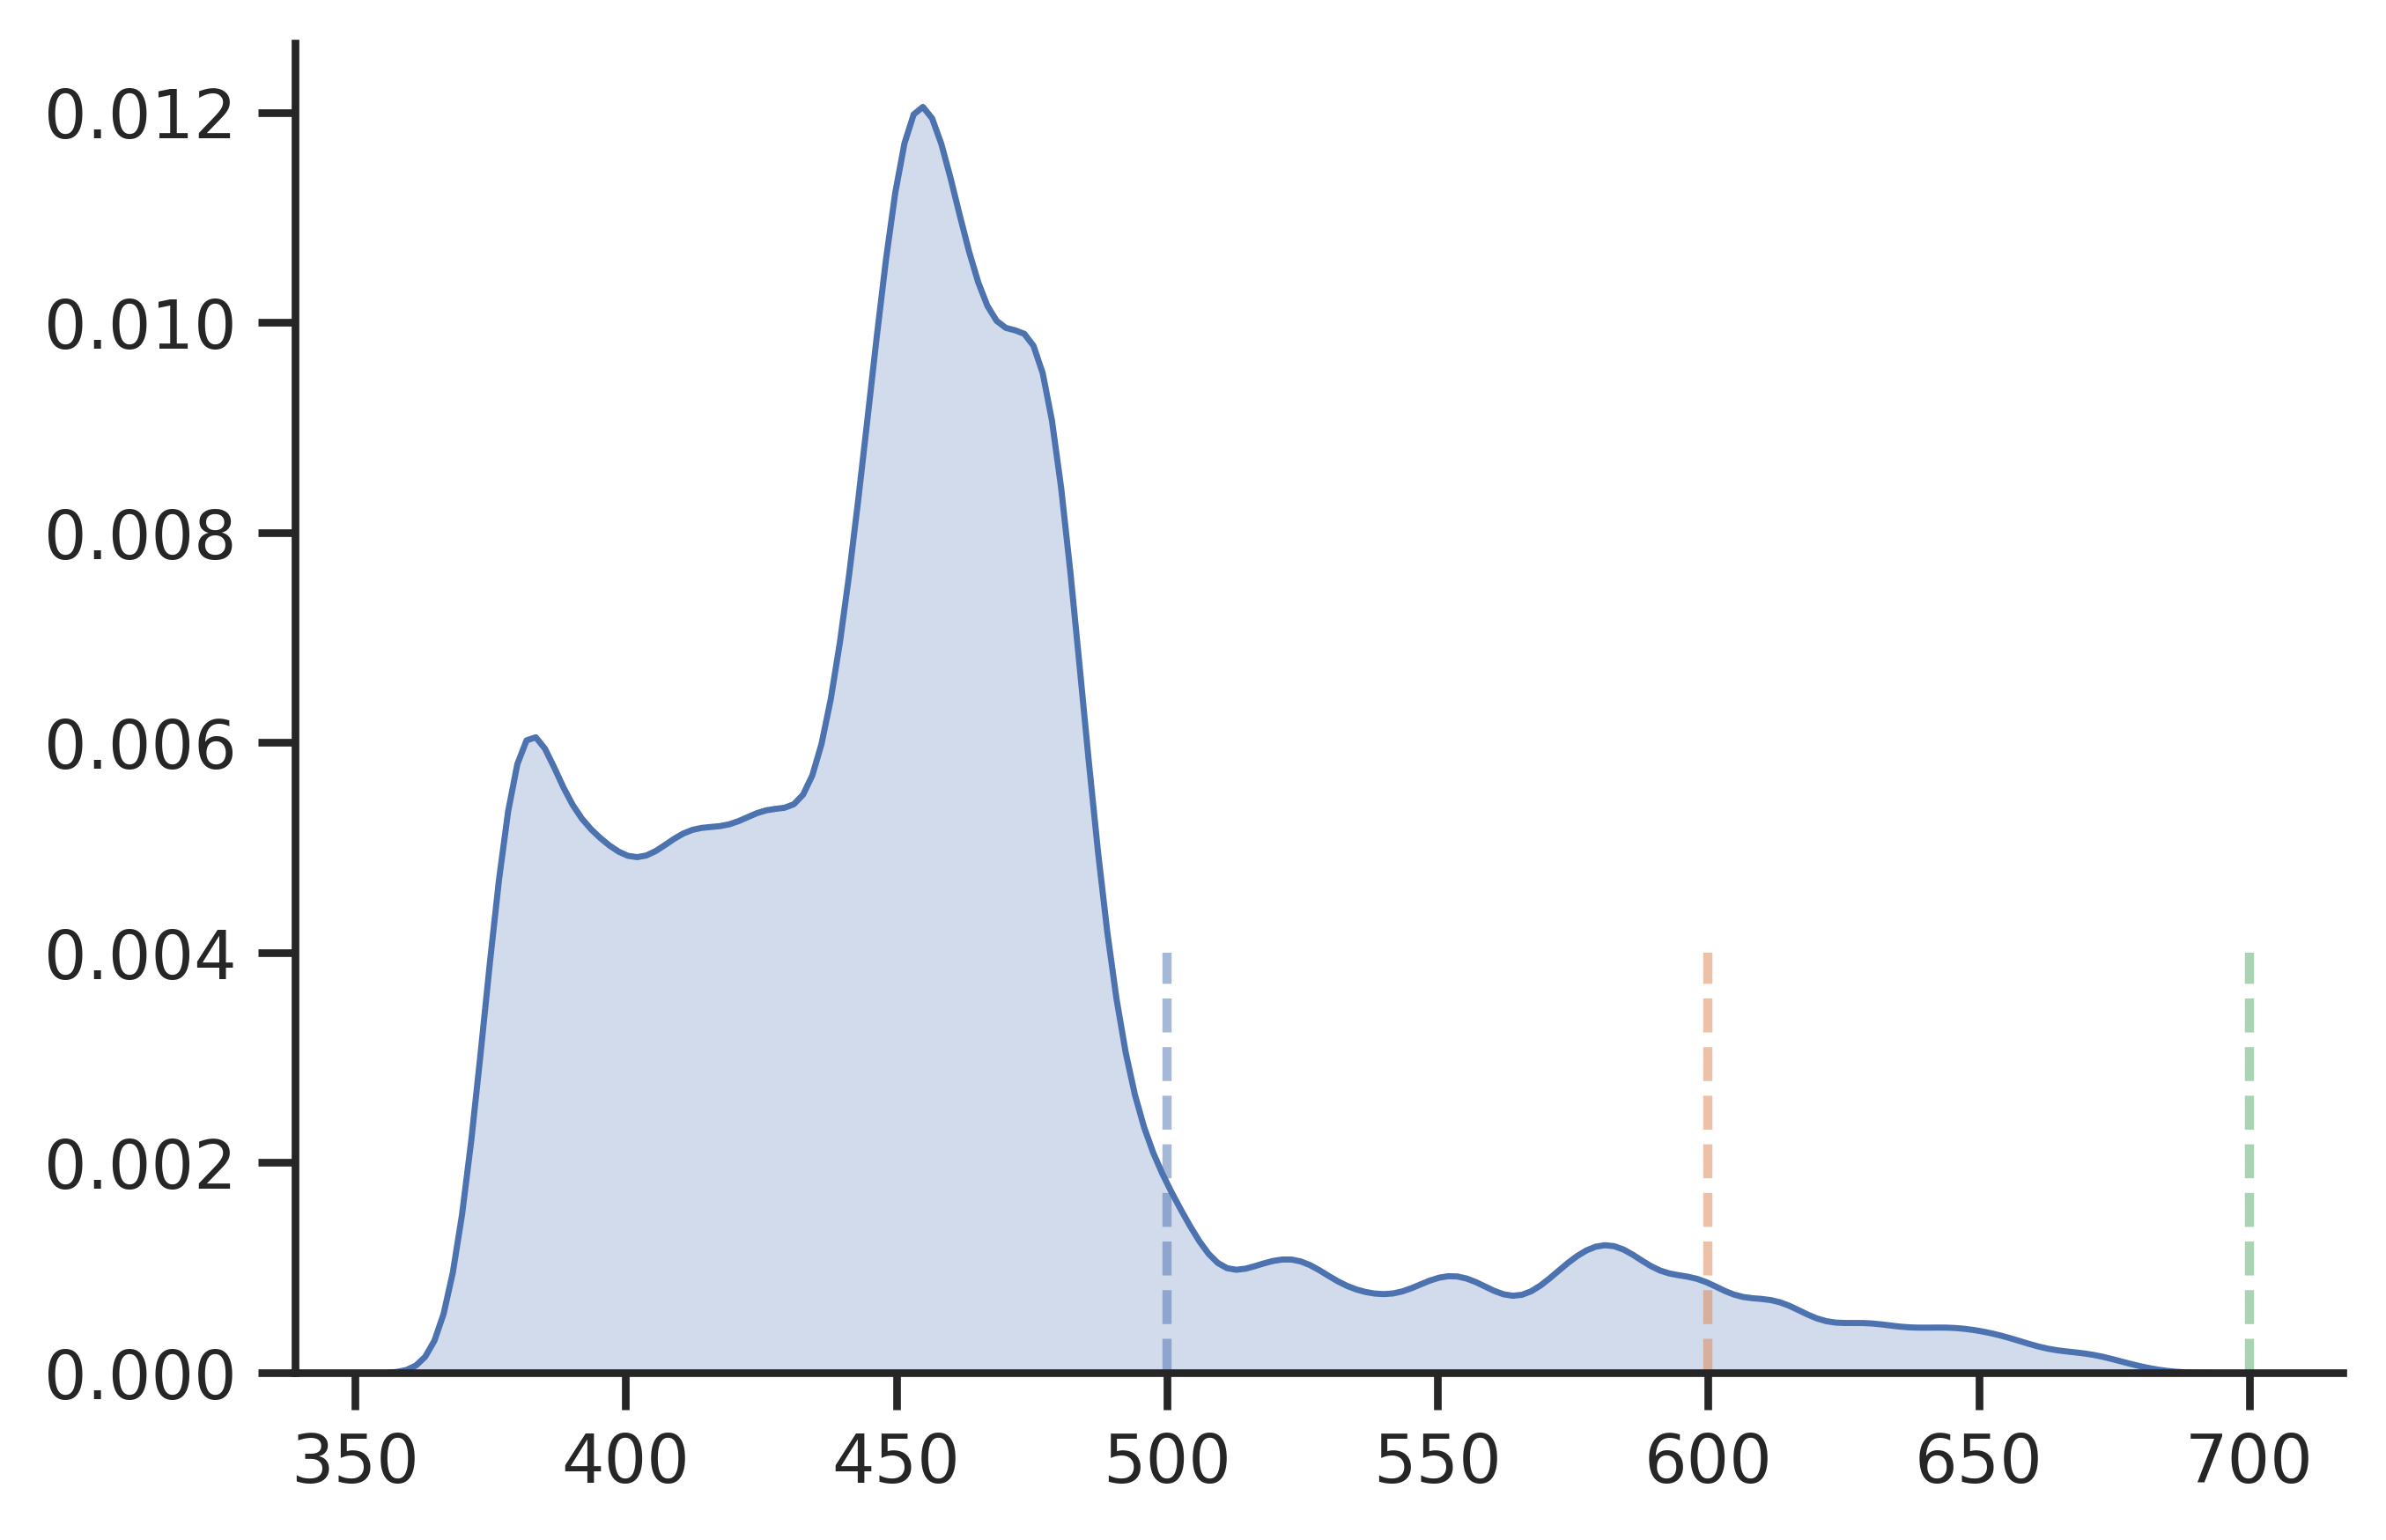

In [694]:
fig,ax = plt.subplots(1,1,dpi=500)

all_z = raw_z.flatten()
thresholds = [350,500,600, 700]


sns.kdeplot(all_z, shade=True,bw_method=0.1, ax=ax)

for t in thresholds[1:]:
    ax.plot([t,t],[0,0.0],'--',alpha=0.5)

raw_z.max()
sns.despine(ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")

In [667]:
np.sum(n_points)

285